# Libraries

In [0]:
%restart_python

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

reference_date = pd.to_datetime("2023-08-01 00:00:00")

In [0]:
df_spark = spark.table("workspace.default.df_sessions_tab") #TABLE SAVED AS "sessions_preprocessed.csv"
df = df_spark.toPandas()

#replace age_bin coming from the delta table as dictionaries with actual pd.cut intervals
bins_range = [df.age_in_2023.min(), 20, 30, 40, 50, 60, 70, 80, 90]
df['age_bin'] = pd.cut(df.age_in_2023, bins=bins_range, right=False)

In [0]:
df.columns

Index(['session_id', 'user_id', 'trip_id', 'session_start', 'session_end',
       'page_clicks', 'flight_discount', 'flight_discount_amount',
       'hotel_discount', 'hotel_discount_amount', 'flight_booked',
       'hotel_booked', 'cancellation', 'birthdate', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'origin_airport', 'destination', 'destination_airport', 'seats',
       'return_flight_booked', 'departure_time', 'return_time', 'checked_bags',
       'trip_airline', 'destination_airport_lat', 'destination_airport_lon',
       'base_fare_usd', 'hotel_name', 'nights_calc', 'rooms', 'check_in_time',
       'check_out_time', 'hotel_price_per_room_night_usd', 'age_in_2023',
       'session_duration_min', 'days_between_flights', 'age_bin', 'status',
       'distance_km', 'duration', 'session_cost', 'booking_window_days',
       'family_session'],
      dtype='object')

#SUMMARY

---
**NIGHTS**
* PROBLEM 1: wrong numbers when compared to check in and out time
  * REASON: they calculated first the check in and out datetime difference in hours and rounded using np.ceil(hours) (so that 23.1 -> 24), then they calculated the number of nights by dividing hours/24 and rounded using np.floor(nights) (so that 1.9 -> 1)
  * SOLUTION: calculate difference between check in and out dates, ignoring the time
* PROBLEM 2: late night check-in: Some check-in have taken place after midnight. Ignoring the time and using only date difference may be misleading in such cases.
  * SOLUTION: I will adjust the night calculation (adding +1) for those trips which check-in happened betweem midnight and 6
* PROBLEM 3: Negative (or sometimes zero) nights
  * REASON: check-in datetime >= check-out datetime, for no understandable reason
  * SOLUTION: I need a way to adjust the check in or out dates (time is impossible to fix, let's fix at least the dates). I noticed that flight dates (departure and return times) are very reliable:
    1. Departure date is always max 1 day before the check-in
    2. Return date is always max 3 days after the check-out
  
    Given these considerations, I adjusted the check-out date, using the return flight date, only for those trips for which:
    * departure flight takes place the same day as the check in
    * return flight takes place the day after the departure (when return is later, we cannot derive the check-out date because of point 2 above)
    * all others were dropped (~131)

CONSIDERATIONS:

* We have "nights_calc" for all those "booked_and_travelled" sessions where hotel was booked

---
**TRIP_ID**

There are 599 Trip_ID that appear twice. One is booking, the other is cancellation of the previous booking.

Something inexplicable: check-in time for these trips (???).

In the overall dataset, there are 606 cancellations. 599 belong to the double-Trip_ID group. The remaining 7 are cancellations of trips booked before 2023 (remember that we filtered the original database to have only sessions that happened > 2023). I will drop these 7 rows, since it makes no sense to have them.

Understanding about it
* Sessions **with a trip_id** and **without cancellation** correspond to **booked trips**
* Sessions **with a trip_id** and **with cancellation** are sessions where booked **trips are cancelled**
* Sessions **without trip_id** correspond to **unbooked trip**

I will create a new column regarding the session status with either one of the following values:
* **booked_and_travelled** (Sessions where a booking is made and the trip is eventually taken)
* **booked_but_cancelled** (Sessions where a booking is made, but that trip is canceled in a later session)
* **cancellation_session** (Sessions whose main action is canceling a previously booked trip)
* **no_booking** (Sessions that end without any booking)

---
**DISTANCES**

* Every session has a home_airport and respective coordinates (no missing value in the whole df)
* Destination airport coordinates are missing ONLY when the flight wasn't booked, or in cancellation sessions
* 2332 (out of 15366) trips (booked_and_travelled) have no destination airport coordinates, because no flight was booked
* 50 (out of 599) trips (booked_but_cancelled) have no destination airport coordinates, because no flight was booked

I calculated the distances between airports wherever possible

---
**DURATION**

Goal: estimate trip duration

Consideration:
* when return flight is booked, we have nr of days between flights
* when hotel is booked, we have nr of nights (also for booked_but_cancelled, which makes no sense, since the trip never happened)
* 16 (out of 15366) trips (booked_and_travelled) have no return and hotel booked, and therefore no nr of nights or days between flights
* 8 (out of 599) trips (booked_but_cancelled) have no return and hotel booked, and therefore no nr of nights or days between flights

Some trip has no hotel booked (i.e. no nr of nights), some other has no flight booked (no days between flights).
We should consider both to estimate the trip duration:
* those sessions with both data, we take the highest one (usually days between flights)
* otherwise, we use the only one that appears in the table

---
**BASEFARE**

Which session has basefare not null:
* all and only those trips with both departure and return flights booked
* 13034 sessions "booked and travelled" (all "booked and travelled" sessions with flight_booked == True)
* 549 sessions "booked but cancelled"
* the 549 cancellation sessions of previous point
---
**ROOM PRICE**
* We have room price for all "booked and travelled" trip where hotel was booked
* No room price for all "booked and travelled" trip where hotel was not booked

#EDA (Overall)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49073 entries, 0 to 49072
Data columns (total 51 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   session_id                      49073 non-null  object        
 1   user_id                         49073 non-null  int64         
 2   trip_id                         16564 non-null  object        
 3   session_start                   49073 non-null  datetime64[ns]
 4   session_end                     49073 non-null  datetime64[ns]
 5   page_clicks                     49073 non-null  int64         
 6   flight_discount                 49073 non-null  bool          
 7   flight_discount_amount          8260 non-null   float64       
 8   hotel_discount                  49073 non-null  bool          
 9   hotel_discount_amount           6189 non-null   float64       
 10  flight_booked                   49073 non-null  bool          
 11  ho

In [0]:
#let's check the data with describe()
df.describe()
#note: only numeric and datetime64 are displayed

,user_id,session_start,session_end,page_clicks,flight_discount_amount,hotel_discount_amount,birthdate,home_airport_lat,home_airport_lon,sign_up_date,seats,departure_time,return_time,checked_bags,destination_airport_lat,destination_airport_lon,base_fare_usd,nights_calc,rooms,check_in_time,check_out_time,hotel_price_per_room_night_usd,age_in_2023,session_duration_min,days_between_flights,distance_km,duration,session_cost,booking_window_days
count,49073.000000,49073,49073,49073.000000,8260.000000,6189.000000,49073,49073.000000,49073.000000,49073,14132.000000,14132,13532,14132.000000,14132.000000,14132.000000,49073.000000,14591.000000,14591.000000,14591,14591,14591.000000,49073.000000,49073.000000,13532.000000,14132.000000,16532.000000,16564.000000,15366.000000
mean,545318.302651,2023-03-21 11:20:13.297475328,2023-03-21 11:23:19.154588416,17.530006,0.139873,0.112175,1982-02-27 07:54:29.586126784,38.427024,-94.190700,2023-01-20 01:31:10.315652352,1.215610,2023-04-15 20:57:27.410132992,2023-04-20 06:33:04.096955392,0.593122,38.610313,-88.943715,151.951011,4.341443,1.194983,2023-04-07 02:00:07.360687104,2023-04-11 07:01:51.520800512,178.029744,41.344568,3.097619,4.446645,2321.474366,4.881684,1272.096049,10.964287
min,23557.000000,2023-01-04 00:01:00,2023-01-04 00:04:23,1.000000,0.050000,0.050000,1935-05-10 00:00:00,21.316000,-157.927000,2021-07-22 00:00:00,1.000000,2023-01-07 07:00:00,2023-01-08 07:00:00,0.000000,-37.008000,-157.927000,0.000000,1.000000,1.000000,2023-01-05 11:00:00,2023-01-08 11:00:00,17.000000,17.000000,0.100000,0.000000,17.673736,0.000000,8.710000,0.405613
25%,517131.000000,2023-02-05 22:39:00,2023-02-05 22:39:46,6.000000,0.100000,0.050000,1974-09-08 00:00:00,33.818000,-112.383000,2023-01-08 00:00:00,1.000000,2023-02-15 15:00:00,2023-02-19 14:00:00,0.000000,33.942000,-112.383000,0.000000,2.000000,1.000000,2023-02-15 13:34:43.747500032,2023-02-19 11:00:00,99.000000,34.000000,0.750000,2.000000,1069.440153,2.000000,529.167500,5.734893
50%,540306.000000,2023-03-09 10:25:00,2023-03-09 10:30:07,13.000000,0.100000,0.100000,1981-10-09 00:00:00,39.103000,-90.035000,2023-01-19 00:00:00,1.000000,2023-03-24 07:00:00,2023-03-27 11:00:00,1.000000,39.872000,-87.752000,0.000000,3.000000,1.000000,2023-03-22 09:53:14.144999936,2023-03-25 11:00:00,148.000000,42.000000,1.600000,3.000000,2068.935165,4.000000,856.425000,7.401481
75%,573922.000000,2023-04-28 10:34:00,2023-04-28 10:34:58,22.000000,0.200000,0.150000,1989-03-17 00:00:00,42.238000,-79.370000,2023-02-05 00:00:00,1.000000,2023-05-24 07:00:00,2023-05-28 07:00:00,1.000000,42.409000,-75.241000,112.540000,5.000000,1.000000,2023-05-16 15:53:24.337499904,2023-05-20 11:00:00,223.000000,49.000000,2.683333,5.000000,3131.132085,6.000000,1441.000000,9.127075
max,844489.000000,2023-07-28 19:58:52,2023-07-28 20:08:52,566.000000,0.600000,0.450000,2006-12-28 00:00:00,61.251000,-63.499000,2023-05-18 00:00:00,8.000000,2024-07-16 07:00:00,2024-07-30 16:00:00,8.000000,55.972000,174.792000,21548.040000,43.000000,4.000000,2024-07-17 00:33:41.625000,2024-07-29 11:00:00,1376.000000,88.000000,120.000000,35.000000,17404.941899,43.000000,27702.000000,365.203032
std,64547.503252,NaN,NaN,21.384562,0.083931,0.062109,NaN,6.187721,18.070441,NaN,0.587418,NaN,NaN,0.678347,6.959262,33.144098,500.761793,3.684480,0.500327,NaN,NaN,118.505507,12.054722,10.909274,3.341217,1956.914251,3.794655,1498.991755,28.809494


In [0]:
df.dtypes

session_id                                object
user_id                                    int64
trip_id                                   object
session_start                     datetime64[ns]
session_end                       datetime64[ns]
page_clicks                                int64
flight_discount                             bool
flight_discount_amount                   float64
hotel_discount                              bool
hotel_discount_amount                    float64
flight_booked                               bool
hotel_booked                                bool
cancellation                                bool
birthdate                         datetime64[ns]
gender                                    object
married                                     bool
has_children                                bool
home_country                              object
home_city                                 object
home_airport                              object
home_airport_lat    

In [0]:
df.select_dtypes(include=['number', 'datetime64']).shape

(49073, 29)

In [0]:
df.select_dtypes(include=['number', 'datetime64']).columns

Index(['user_id', 'session_start', 'session_end', 'page_clicks',
       'flight_discount_amount', 'hotel_discount_amount', 'birthdate',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date', 'seats',
       'departure_time', 'return_time', 'checked_bags',
       'destination_airport_lat', 'destination_airport_lon', 'base_fare_usd',
       'nights_calc', 'rooms', 'check_in_time', 'check_out_time',
       'hotel_price_per_room_night_usd', 'age_in_2023', 'session_duration_min',
       'days_between_flights', 'distance_km', 'duration', 'session_cost',
       'booking_window_days'],
      dtype='object')

## Histograms (Univariate)

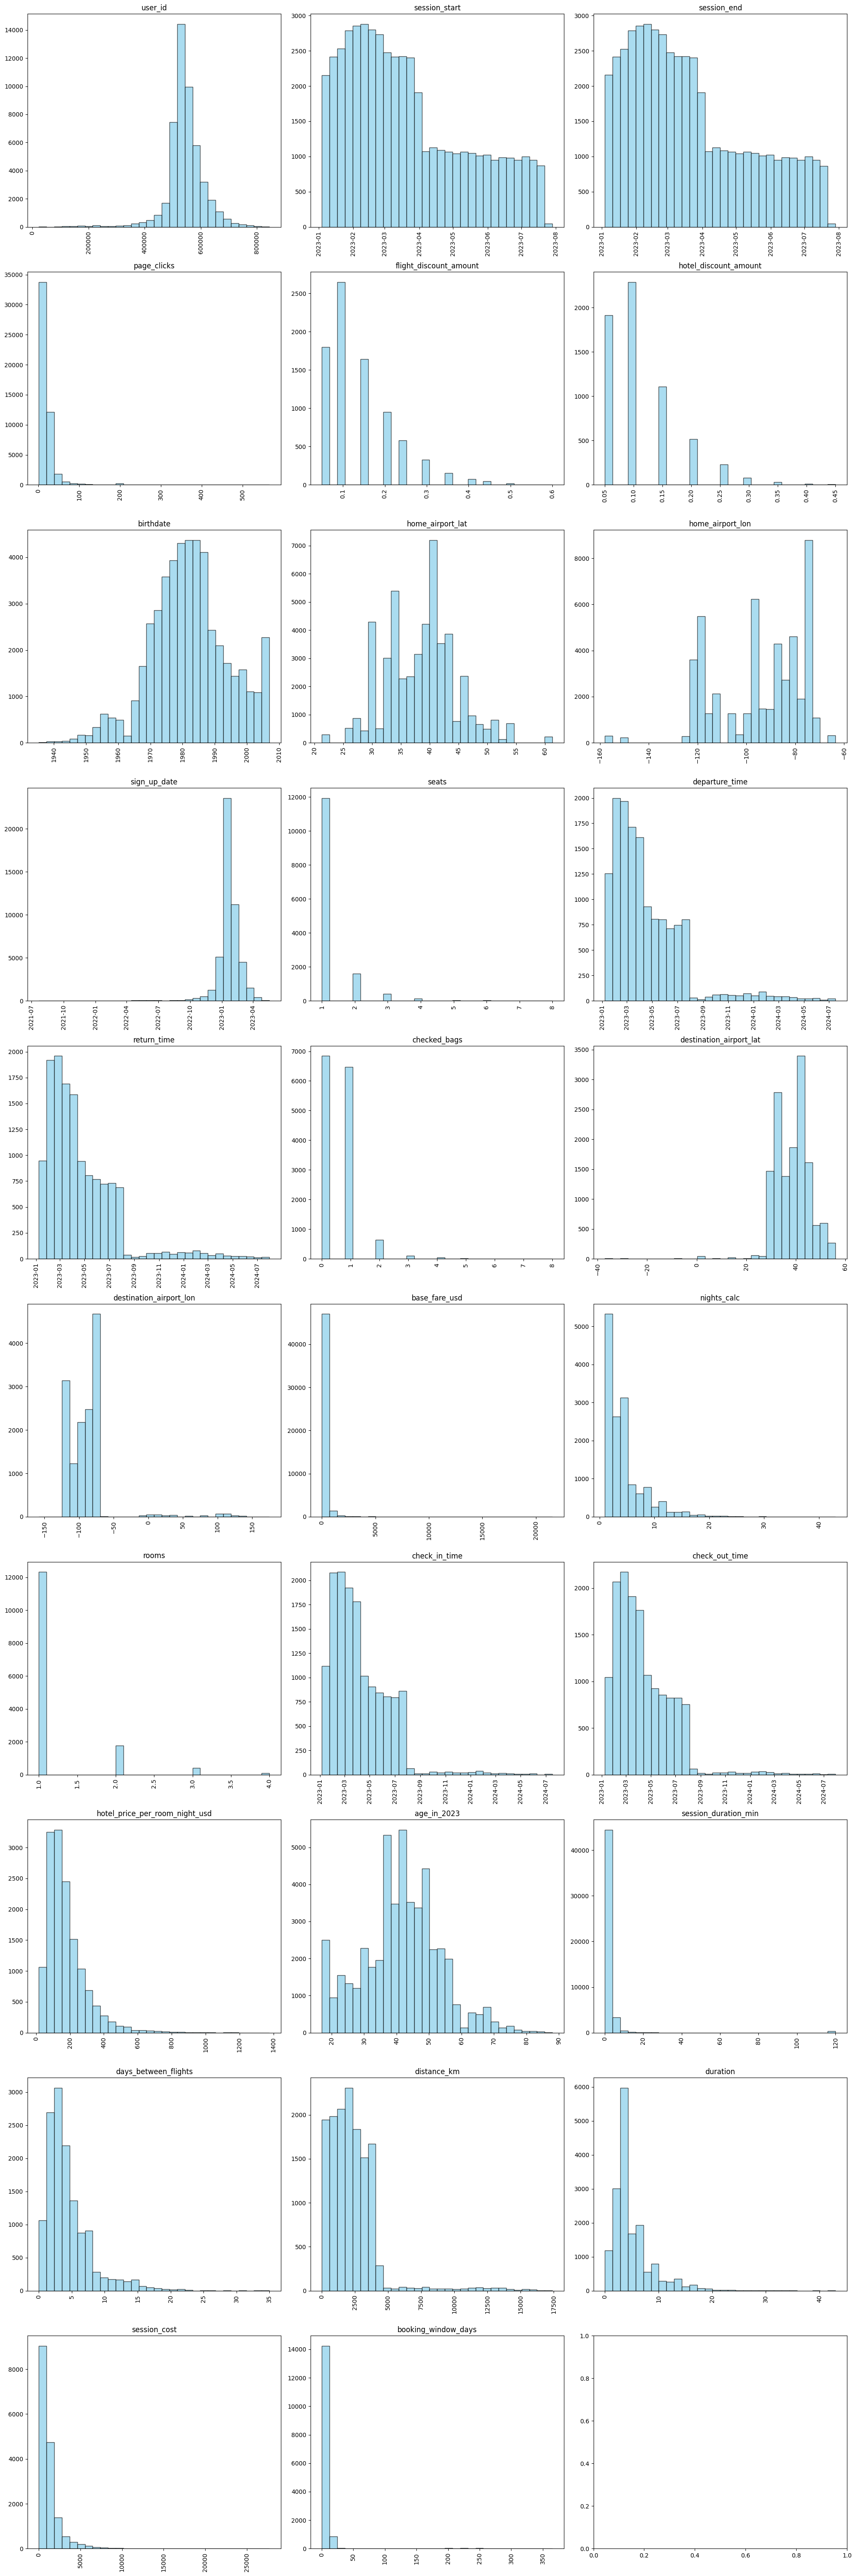

In [0]:
n_plots = len(df.select_dtypes(include=['number', 'datetime64']).columns)

n_col = 3
fig, axes = plt.subplots(nrows=int(np.ceil(n_plots/n_col)), ncols=n_col, figsize=(20,60))

for i, ax in zip(df.select_dtypes(include=['number', 'datetime64']).columns, axes.flatten()):
    ax.hist(df[i], bins=30, alpha=0.7, edgecolor='black', color='skyblue')
    plt.setp(ax.get_xticklabels(), rotation=90)
    ax.set_title(i)
plt.tight_layout()
plt.show()   

## Barplots (Univariate)

In [0]:
df.select_dtypes(exclude=['number', 'datetime64']).columns

Index(['session_id', 'trip_id', 'flight_discount', 'hotel_discount',
       'flight_booked', 'hotel_booked', 'cancellation', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'origin_airport', 'destination', 'destination_airport',
       'return_flight_booked', 'trip_airline', 'hotel_name', 'age_bin',
       'status', 'family_session'],
      dtype='object')

In [0]:
df.select_dtypes(exclude=['number', 'datetime64']).nunique()

session_id              49073
trip_id                 15965
flight_discount             2
hotel_discount              2
flight_booked               2
hotel_booked                2
cancellation                2
gender                      3
married                     2
has_children                2
home_country                2
home_city                 105
home_airport              159
origin_airport            159
destination               125
destination_airport       183
return_flight_booked        2
trip_airline              173
hotel_name                956
age_bin                     8
status                      4
family_session              2
dtype: int64

In [0]:
#replace bool with string in order to be able to plot them
df_categorical = df.select_dtypes(exclude=['number', 'datetime64'])
bool_cols = df_categorical.select_dtypes(include='bool').columns
df_categorical[bool_cols] = df_categorical[bool_cols].replace({True: 'true', False: 'false'})

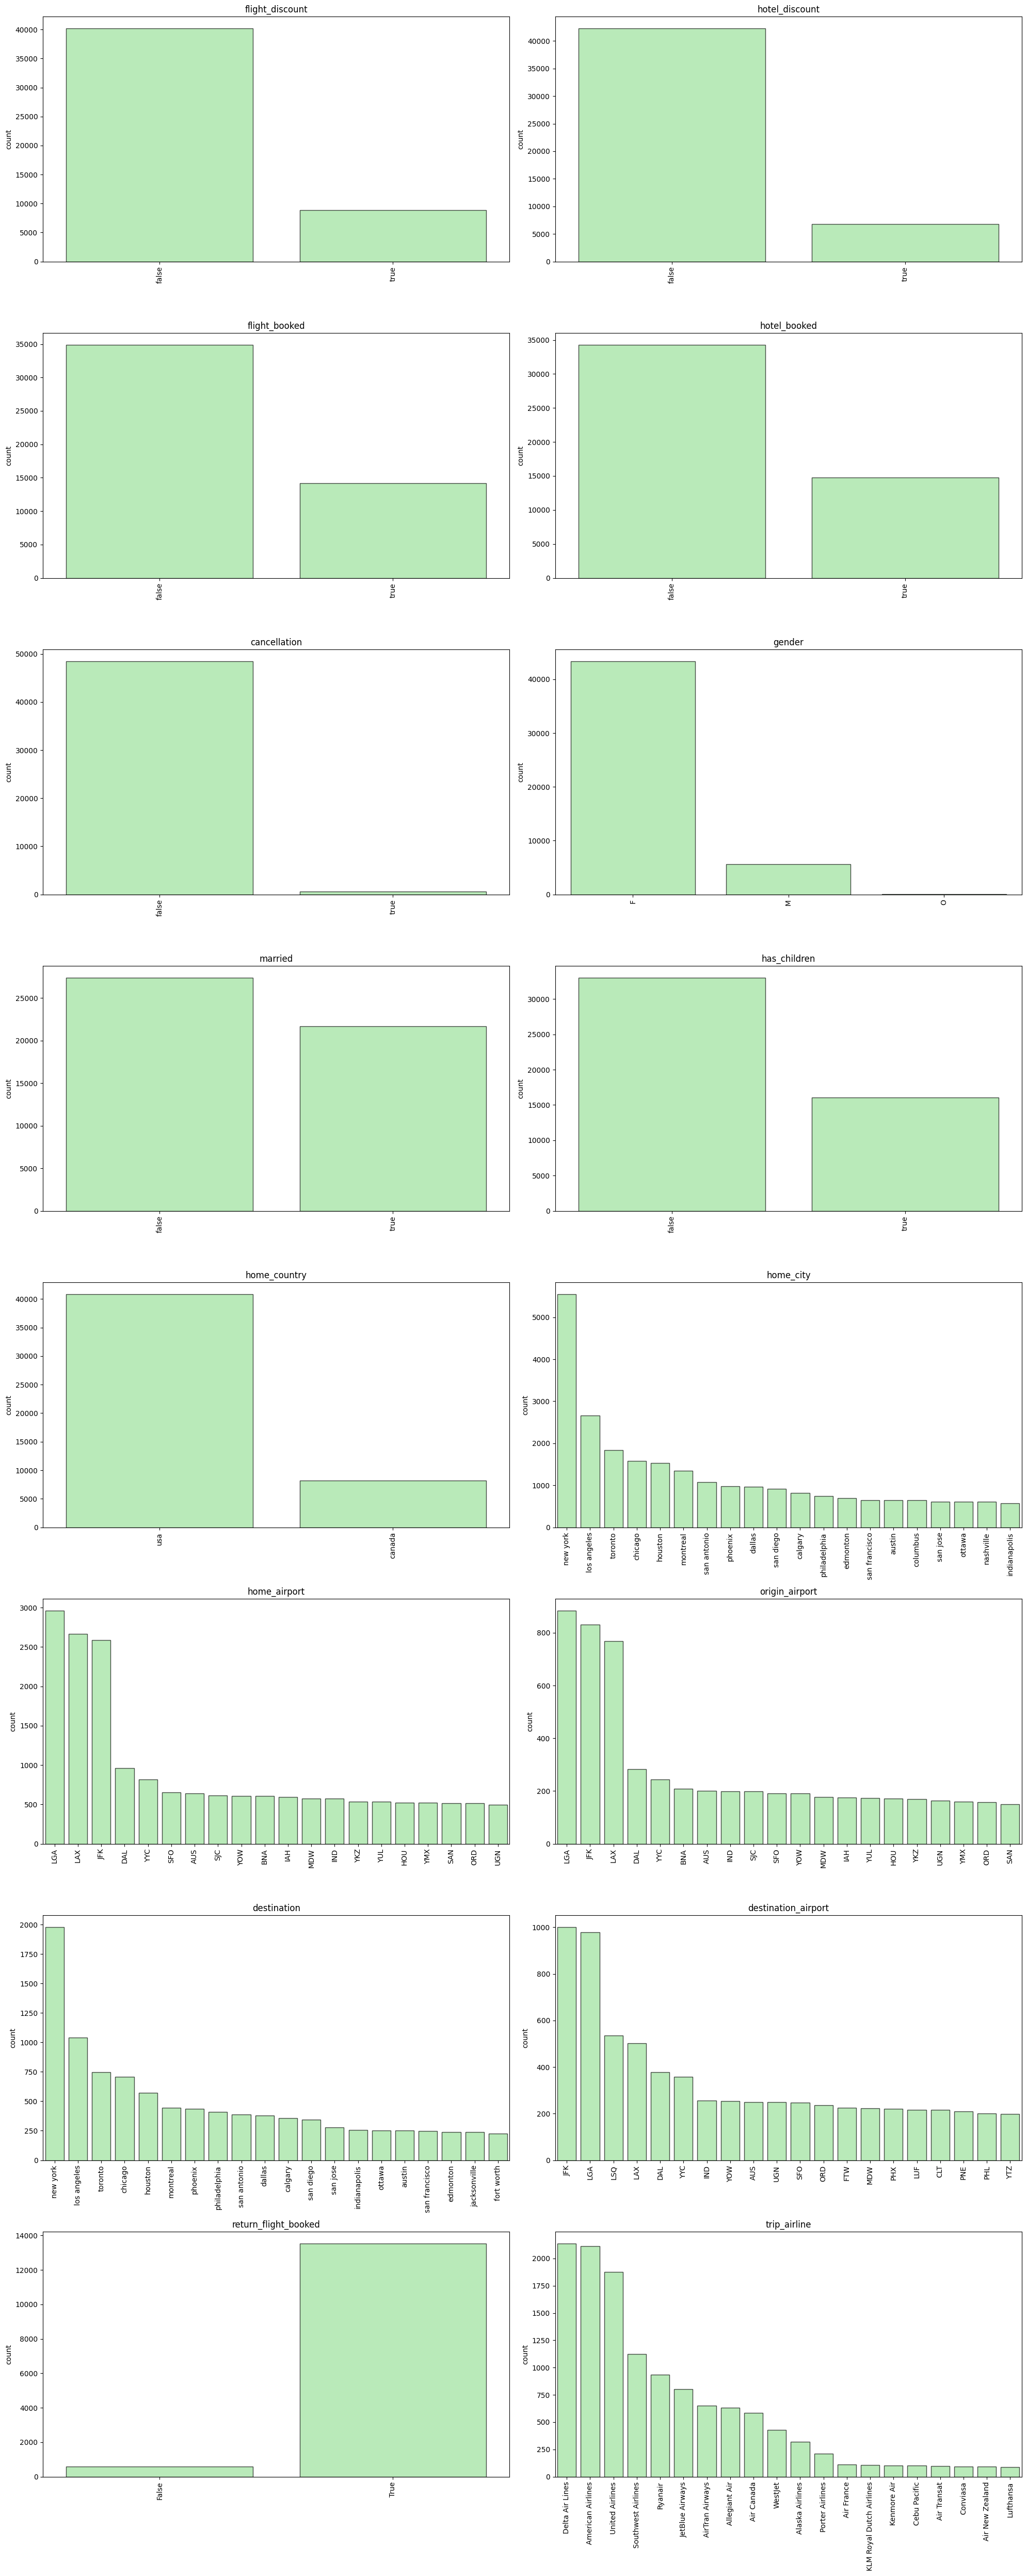

In [0]:
#list of categorical features worth plotting
list_cat_features = ['flight_discount', 'hotel_discount',
       'flight_booked', 'hotel_booked', 'cancellation', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'origin_airport', 'destination', 'destination_airport',
       'return_flight_booked', 'trip_airline']

n_plots = len(list_cat_features)

#plots
n_col = 2

fig, axes = plt.subplots(nrows=int(np.ceil(n_plots/n_col)), ncols=n_col, figsize=(20,50))

for i, ax in zip(list_cat_features, axes.flatten()):
    sns.barplot(data=df_categorical[[i]].value_counts().head(20).reset_index(), x=i, y='count', ax=ax, alpha=0.7, edgecolor='black', color='lightgreen')
    ax.set_title(i)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

interesting things to keep in mind:
* flight_booked and hotel_booked have mainly "false". It means that no flight and hotel are booked in most of then sections: it can be interesting to understand why
* cancellation rate is very low (false is by far the most popular value in that column). However, a deep analysis on those who cancelled the trip might give some interesting insights. Anyway we're interested in decreasing cancellation rate even though it's already quite low.

### some detailed EDA

In [0]:
print("page clicks and session duration impact on flight booking")
df.groupby('flight_booked')[['page_clicks', 'session_duration_min']].mean().round(2)

page clicks and session duration impact on flight booking


,page_clicks,session_duration_min
flight_booked,,
False,12.04,1.50
True,31.03,7.04


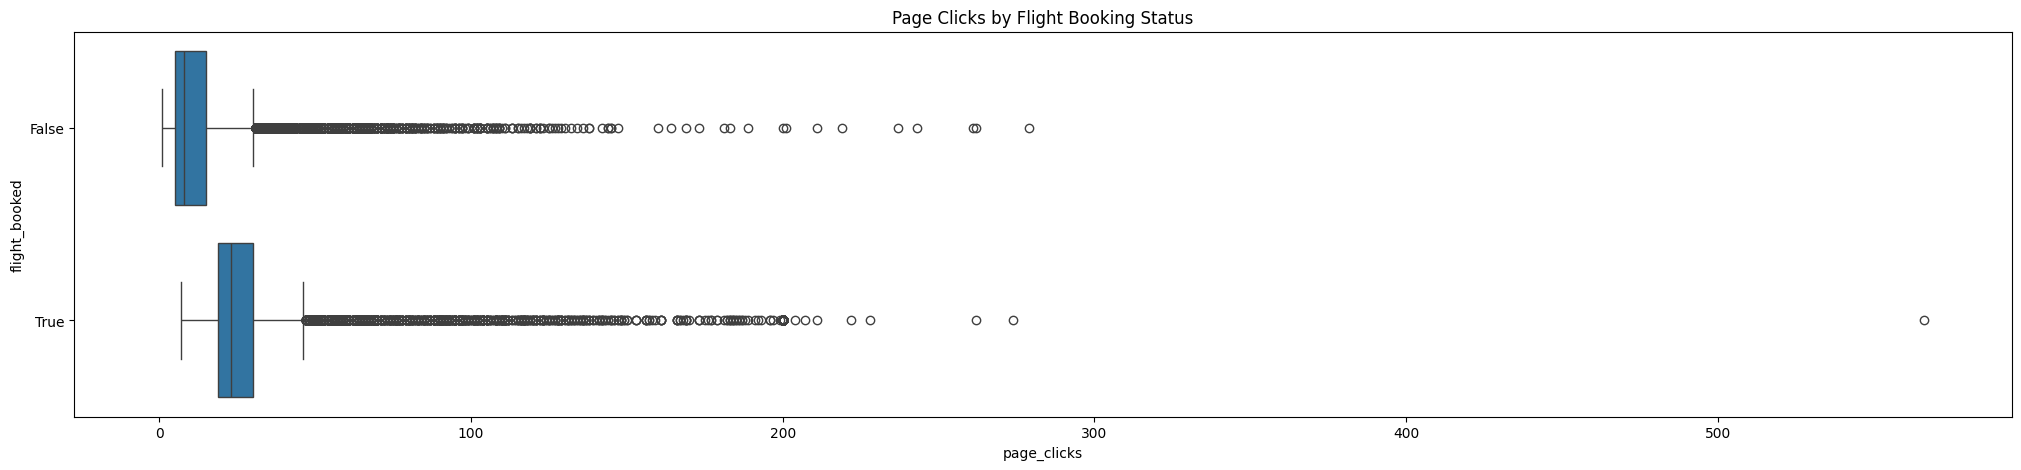

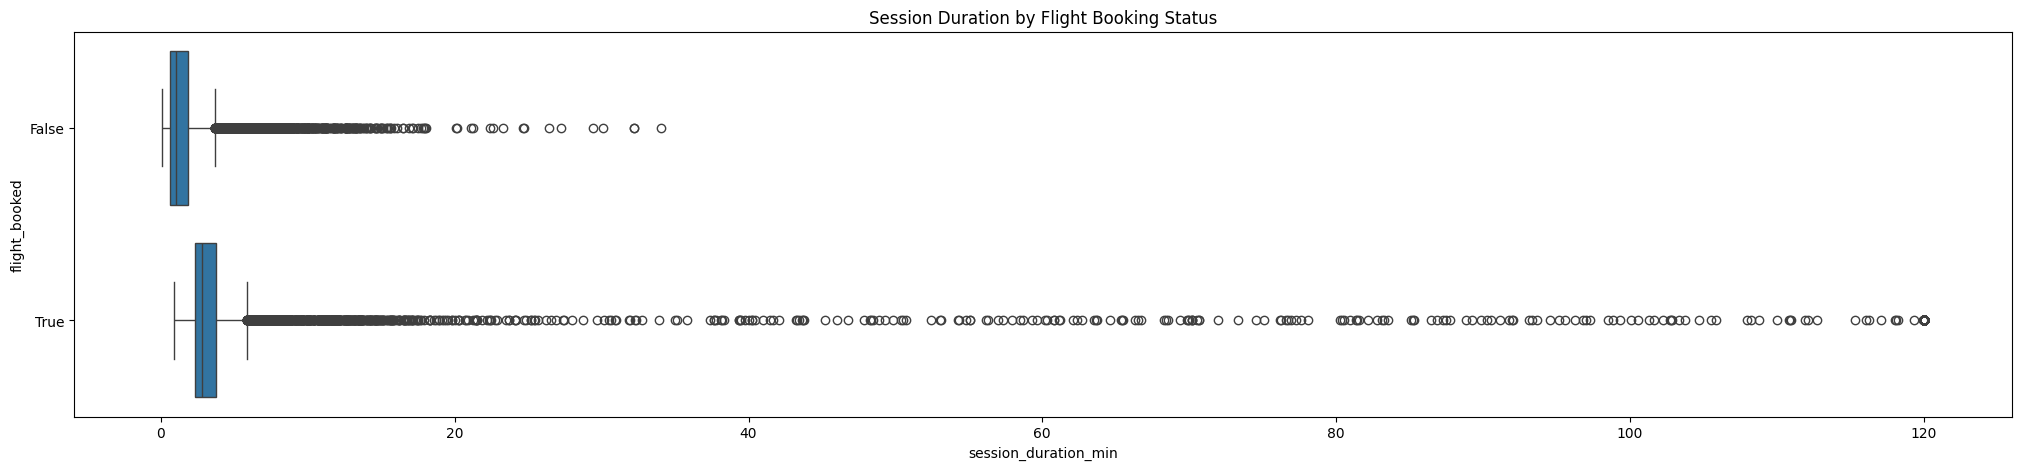

In [0]:
plt.figure(figsize=(25,5))
sns.boxplot(data=df, y='flight_booked', x='page_clicks', orient='h')  # orient='h' for horizontal boxplot
plt.title("Page Clicks by Flight Booking Status")
#plt.xlim(-30,500)
plt.show()

print()

plt.figure(figsize=(25,5))
sns.boxplot(data=df, y='flight_booked', x='session_duration_min', orient='h')  # orient='h' for horizontal boxplot
plt.title("Session Duration by Flight Booking Status")
#plt.xlim(-30,500)
plt.show()

In [0]:
print("Family Status Impact on Trip Attributes (mode)")
df.groupby('has_children')[['nights_calc', 'rooms', 'checked_bags', 'seats']].agg(lambda x: x.mode()[0])

Family Status Impact on Trip Attributes (mode)


,nights_calc,rooms,checked_bags,seats
has_children,,,,
False,2.0,1.0,0.0,1.0
True,2.0,1.0,0.0,1.0


using the mean to find what we saw above can be useful as first insight. However, more interesting might be creating a boxplot and see more details about why flight were booked or not, or what happens where they have children or not...

## Boxplots (Univariate)

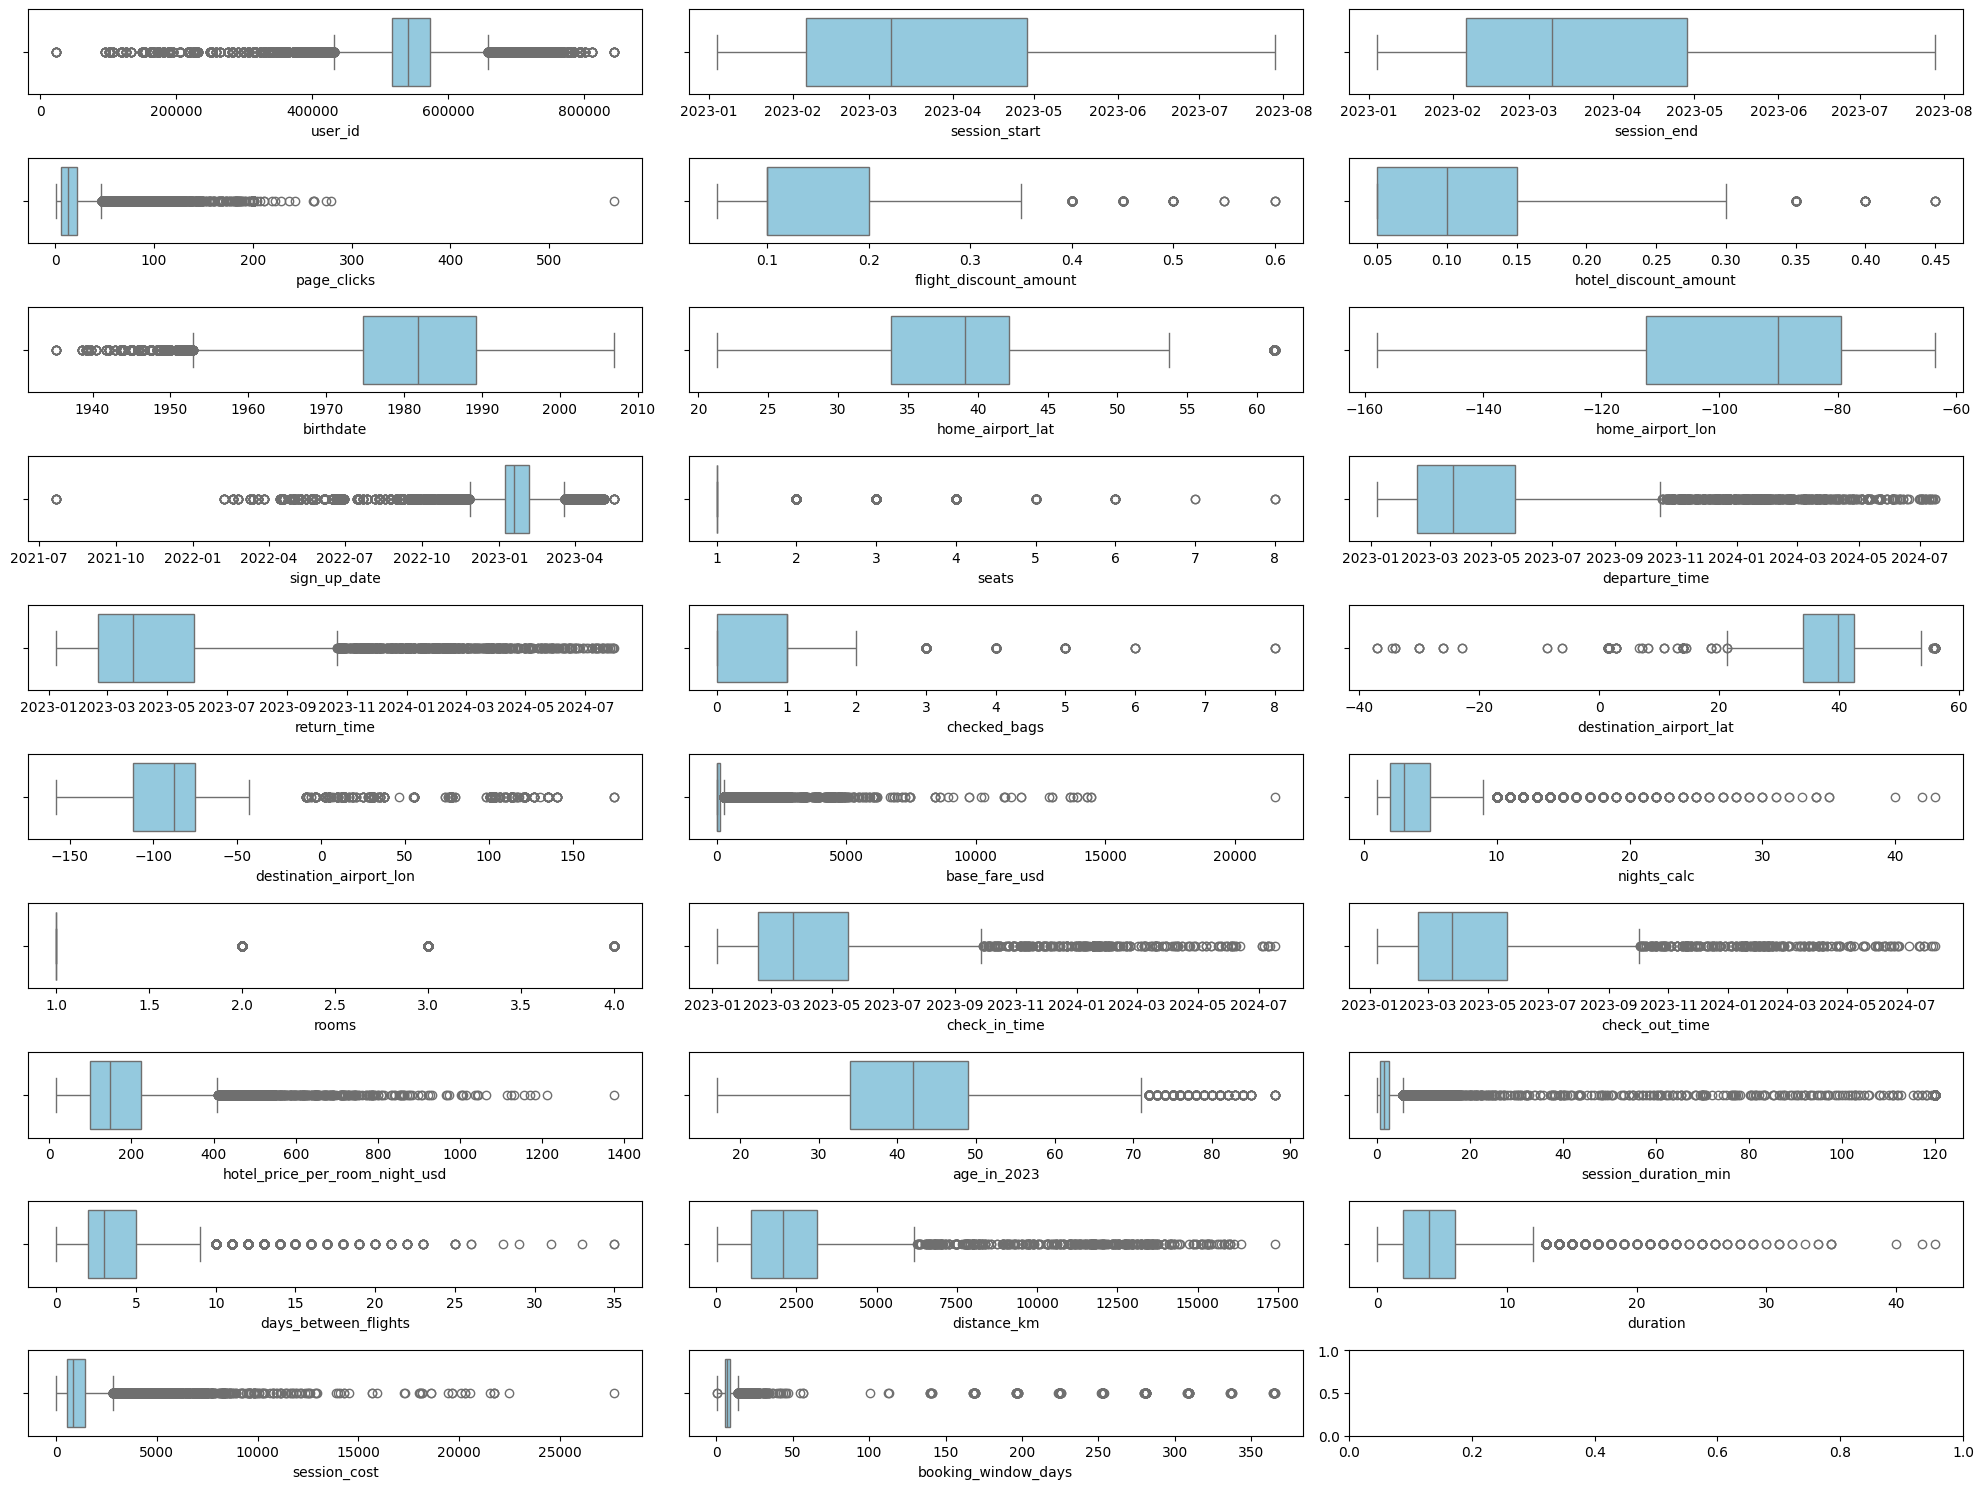

In [0]:
n_plots = len(df.select_dtypes(include=['number', 'datetime64']).columns)

n_col = 3
fig, axes = plt.subplots(nrows=int(np.ceil(n_plots/n_col)), ncols=n_col, figsize=(20,15))

for i, ax in zip(df.select_dtypes(include=['number', 'datetime64']).columns, axes.flatten()):
    sns.boxplot(x=df[i], ax=ax, color='skyblue')
plt.tight_layout()
plt.show()

## Heatmap (Multivariate)

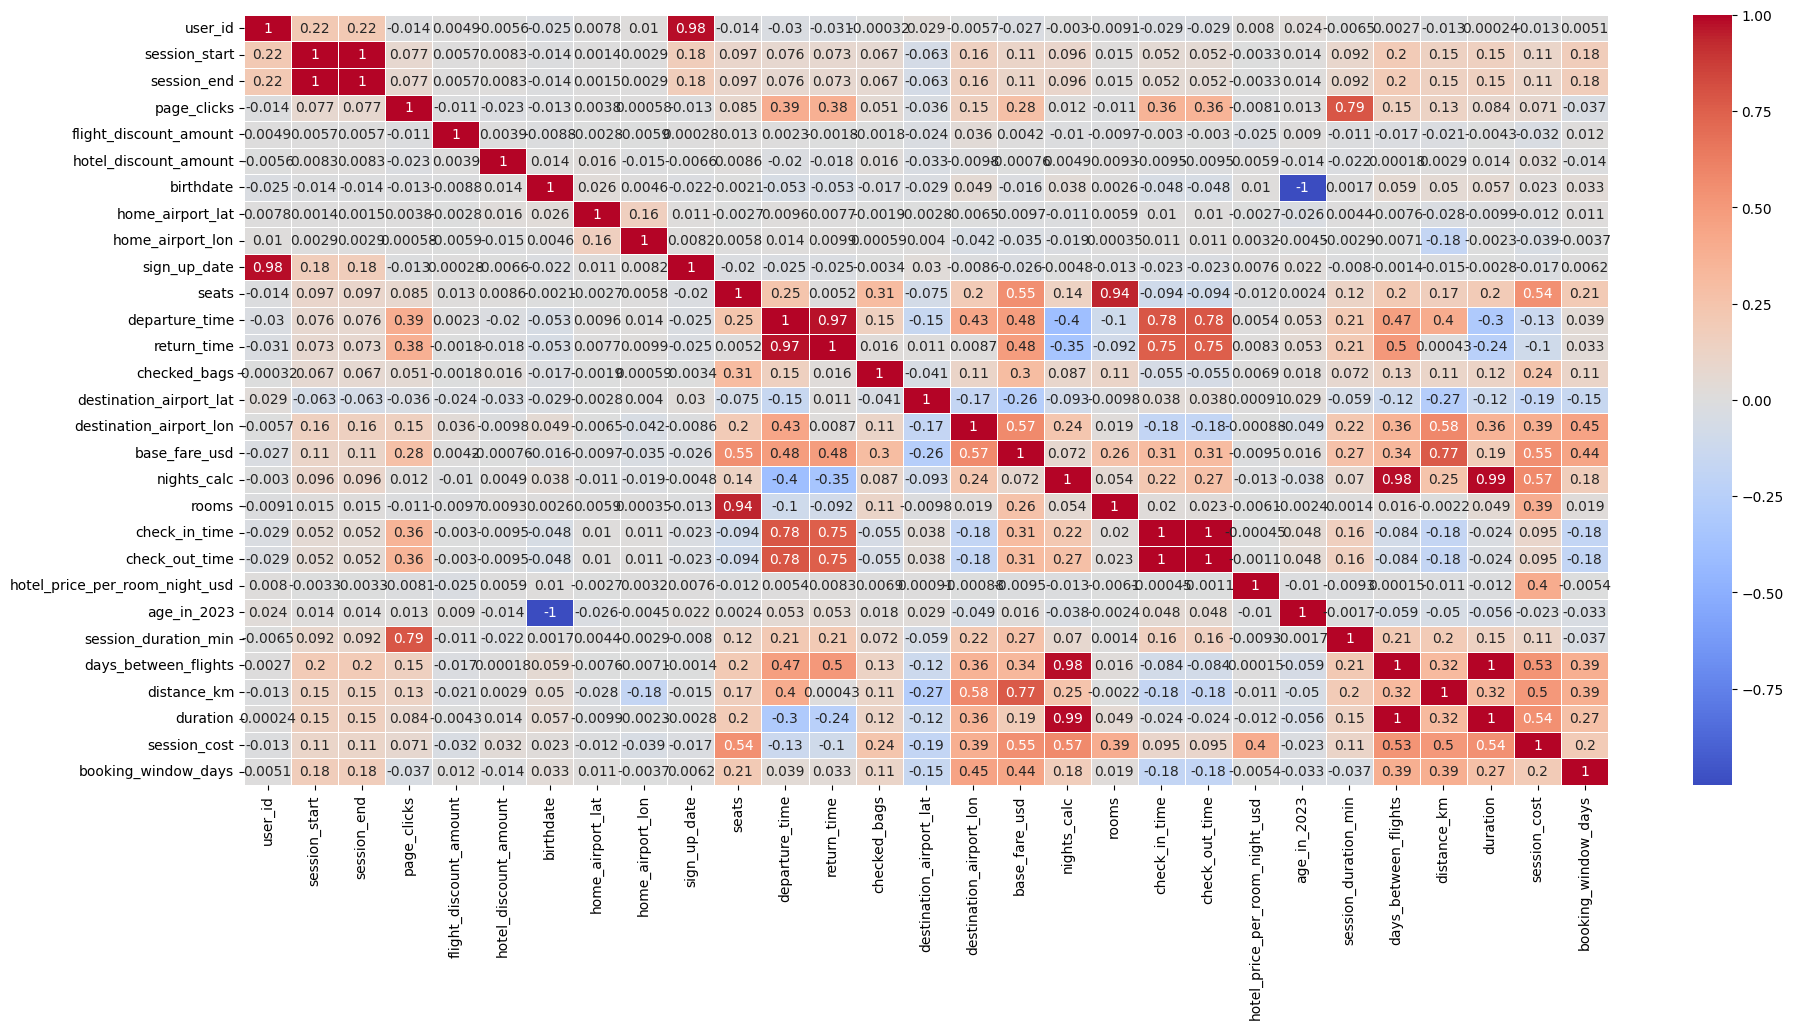

In [0]:
df_num_date = df.select_dtypes(include=['number', 'datetime64'])
correlation_matrix = df_num_date.corr(method='pearson')
plt.figure(figsize=(22, 10))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

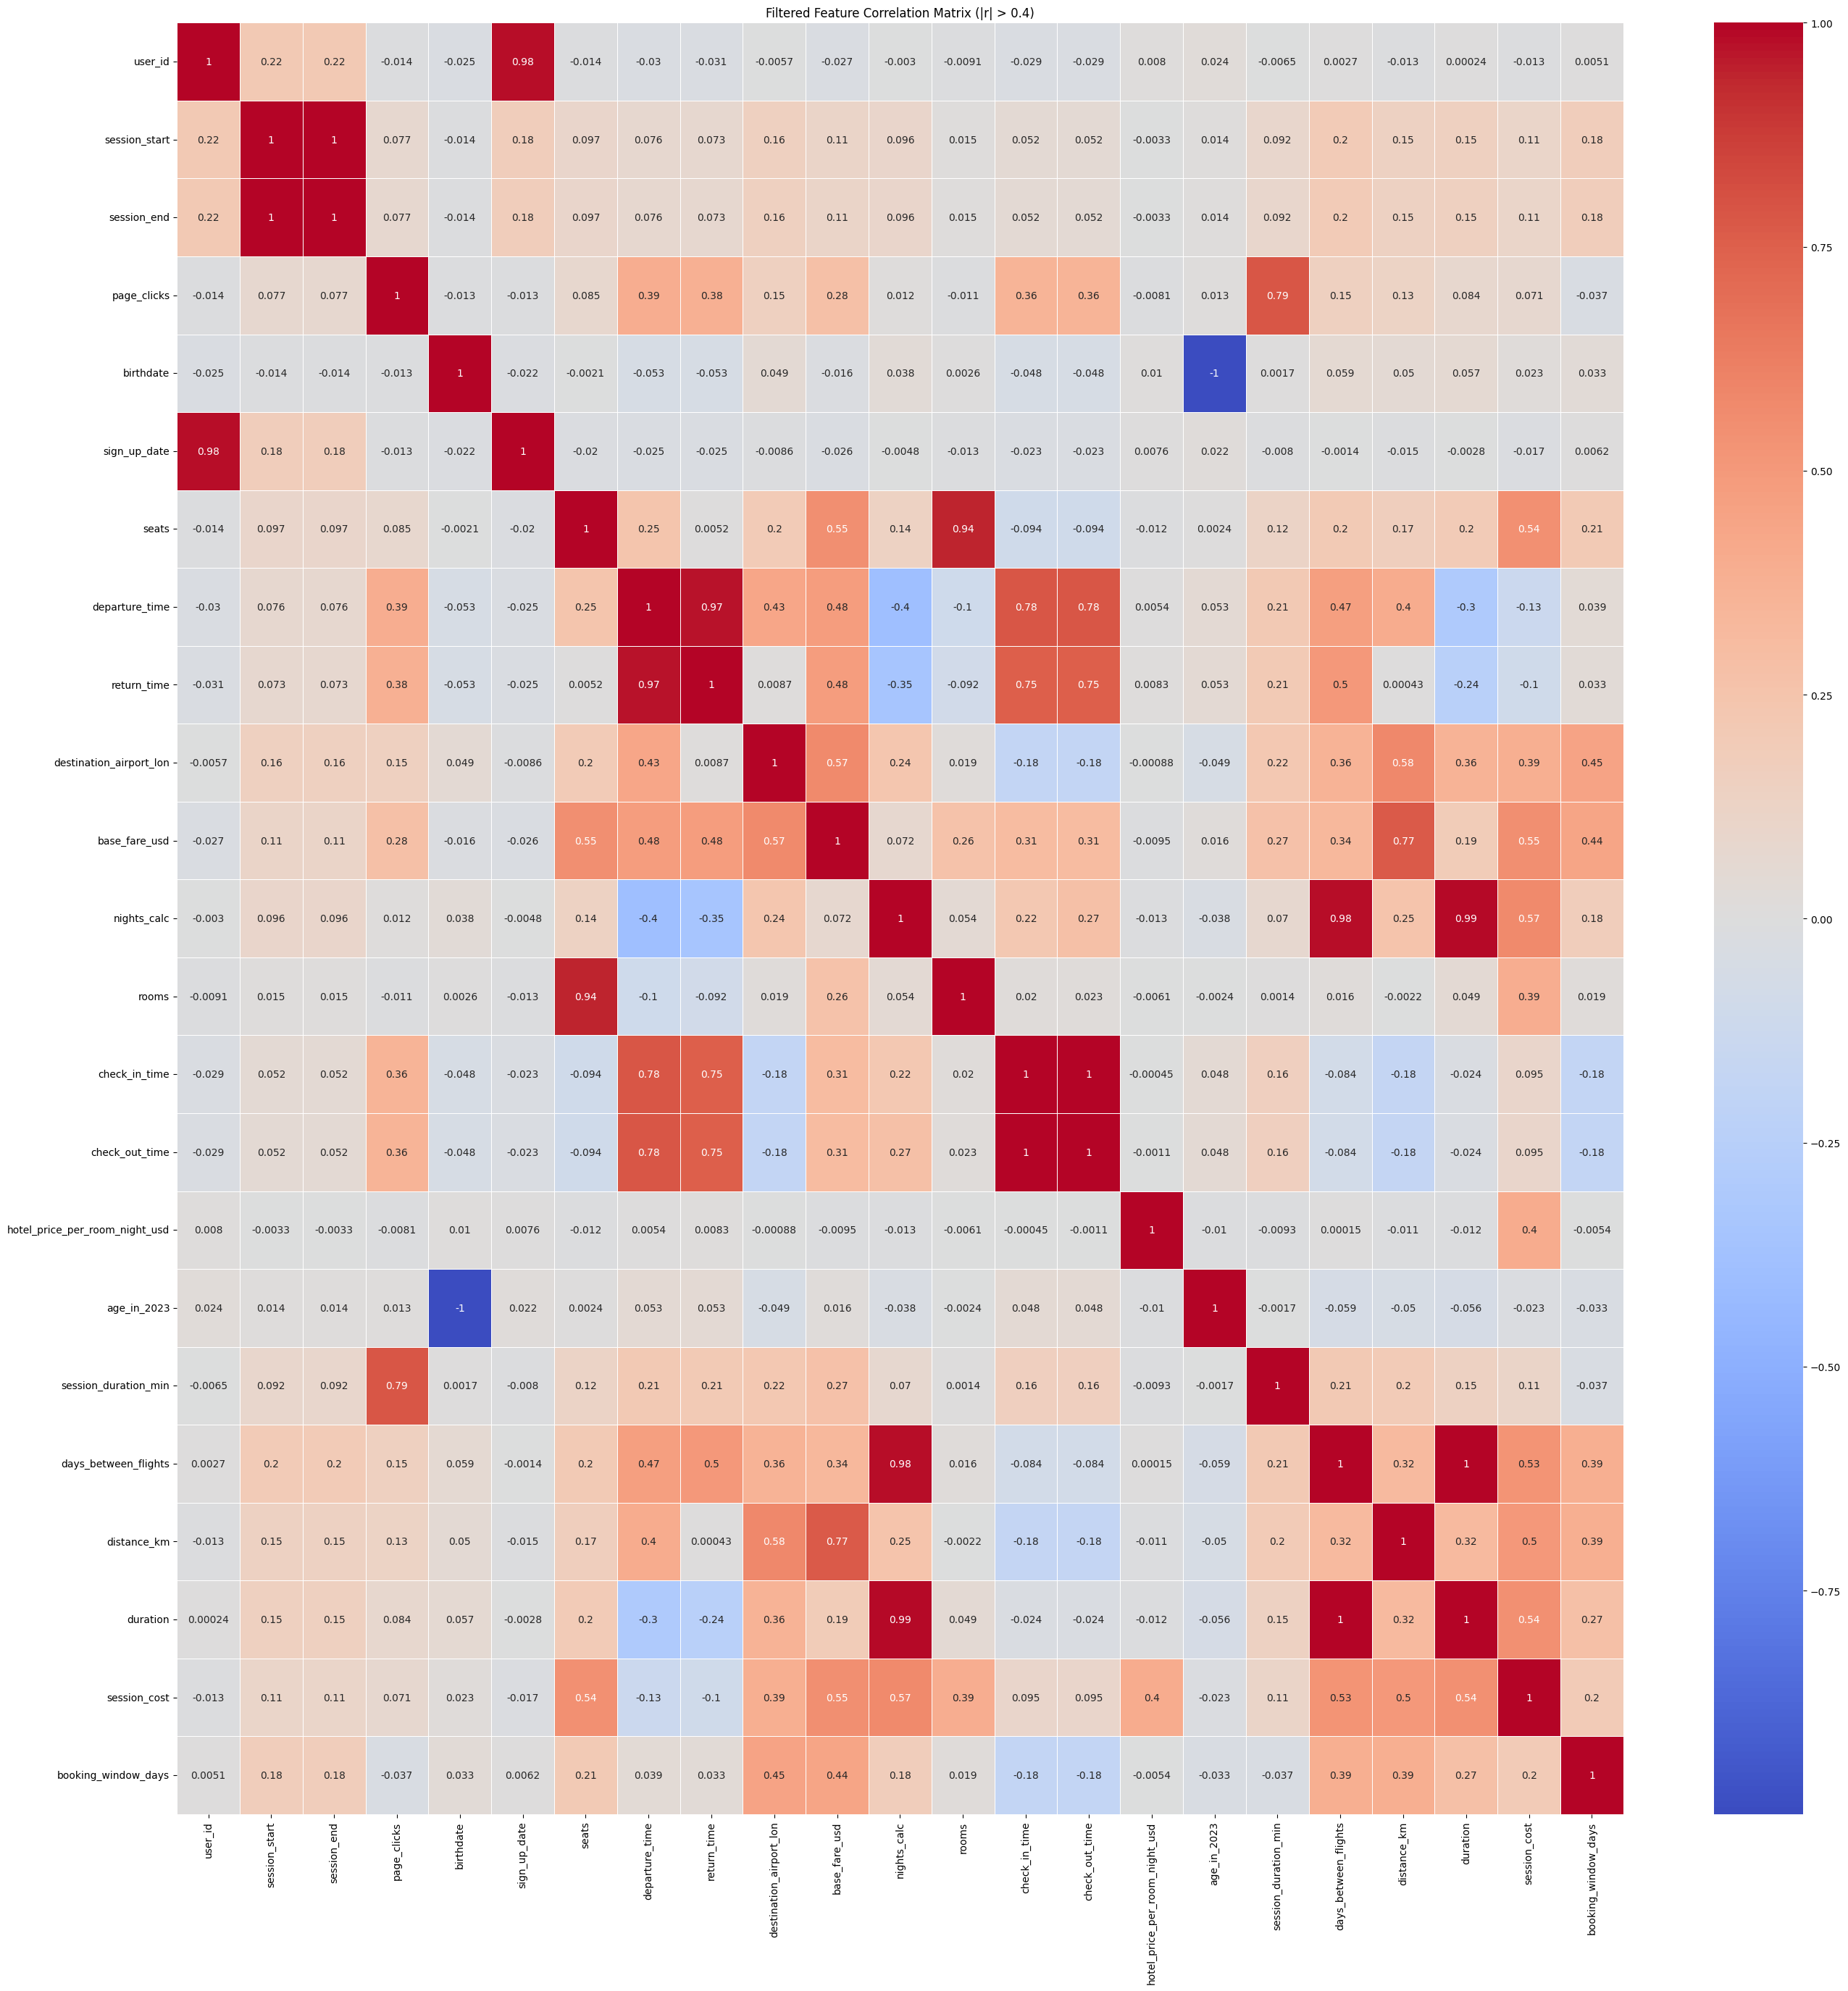

In [0]:
# Identify features with at least one absolute correlation > 0.4 (excluding diagonal)
mask = np.eye(correlation_matrix.shape[0], dtype=bool)
corr_no_diag = correlation_matrix.mask(mask)
features_to_plot = corr_no_diag.columns[(corr_no_diag.abs() > 0.4).any()]

# Filter the correlation matrix
filtered_corr = correlation_matrix.loc[features_to_plot, features_to_plot]

plt.figure(figsize=(len(features_to_plot)*1.2, len(features_to_plot)*1.2))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Filtered Feature Correlation Matrix (|r| > 0.4)")
plt.tight_layout()
plt.show()

#EDA (By Session Status)

## some numeric features

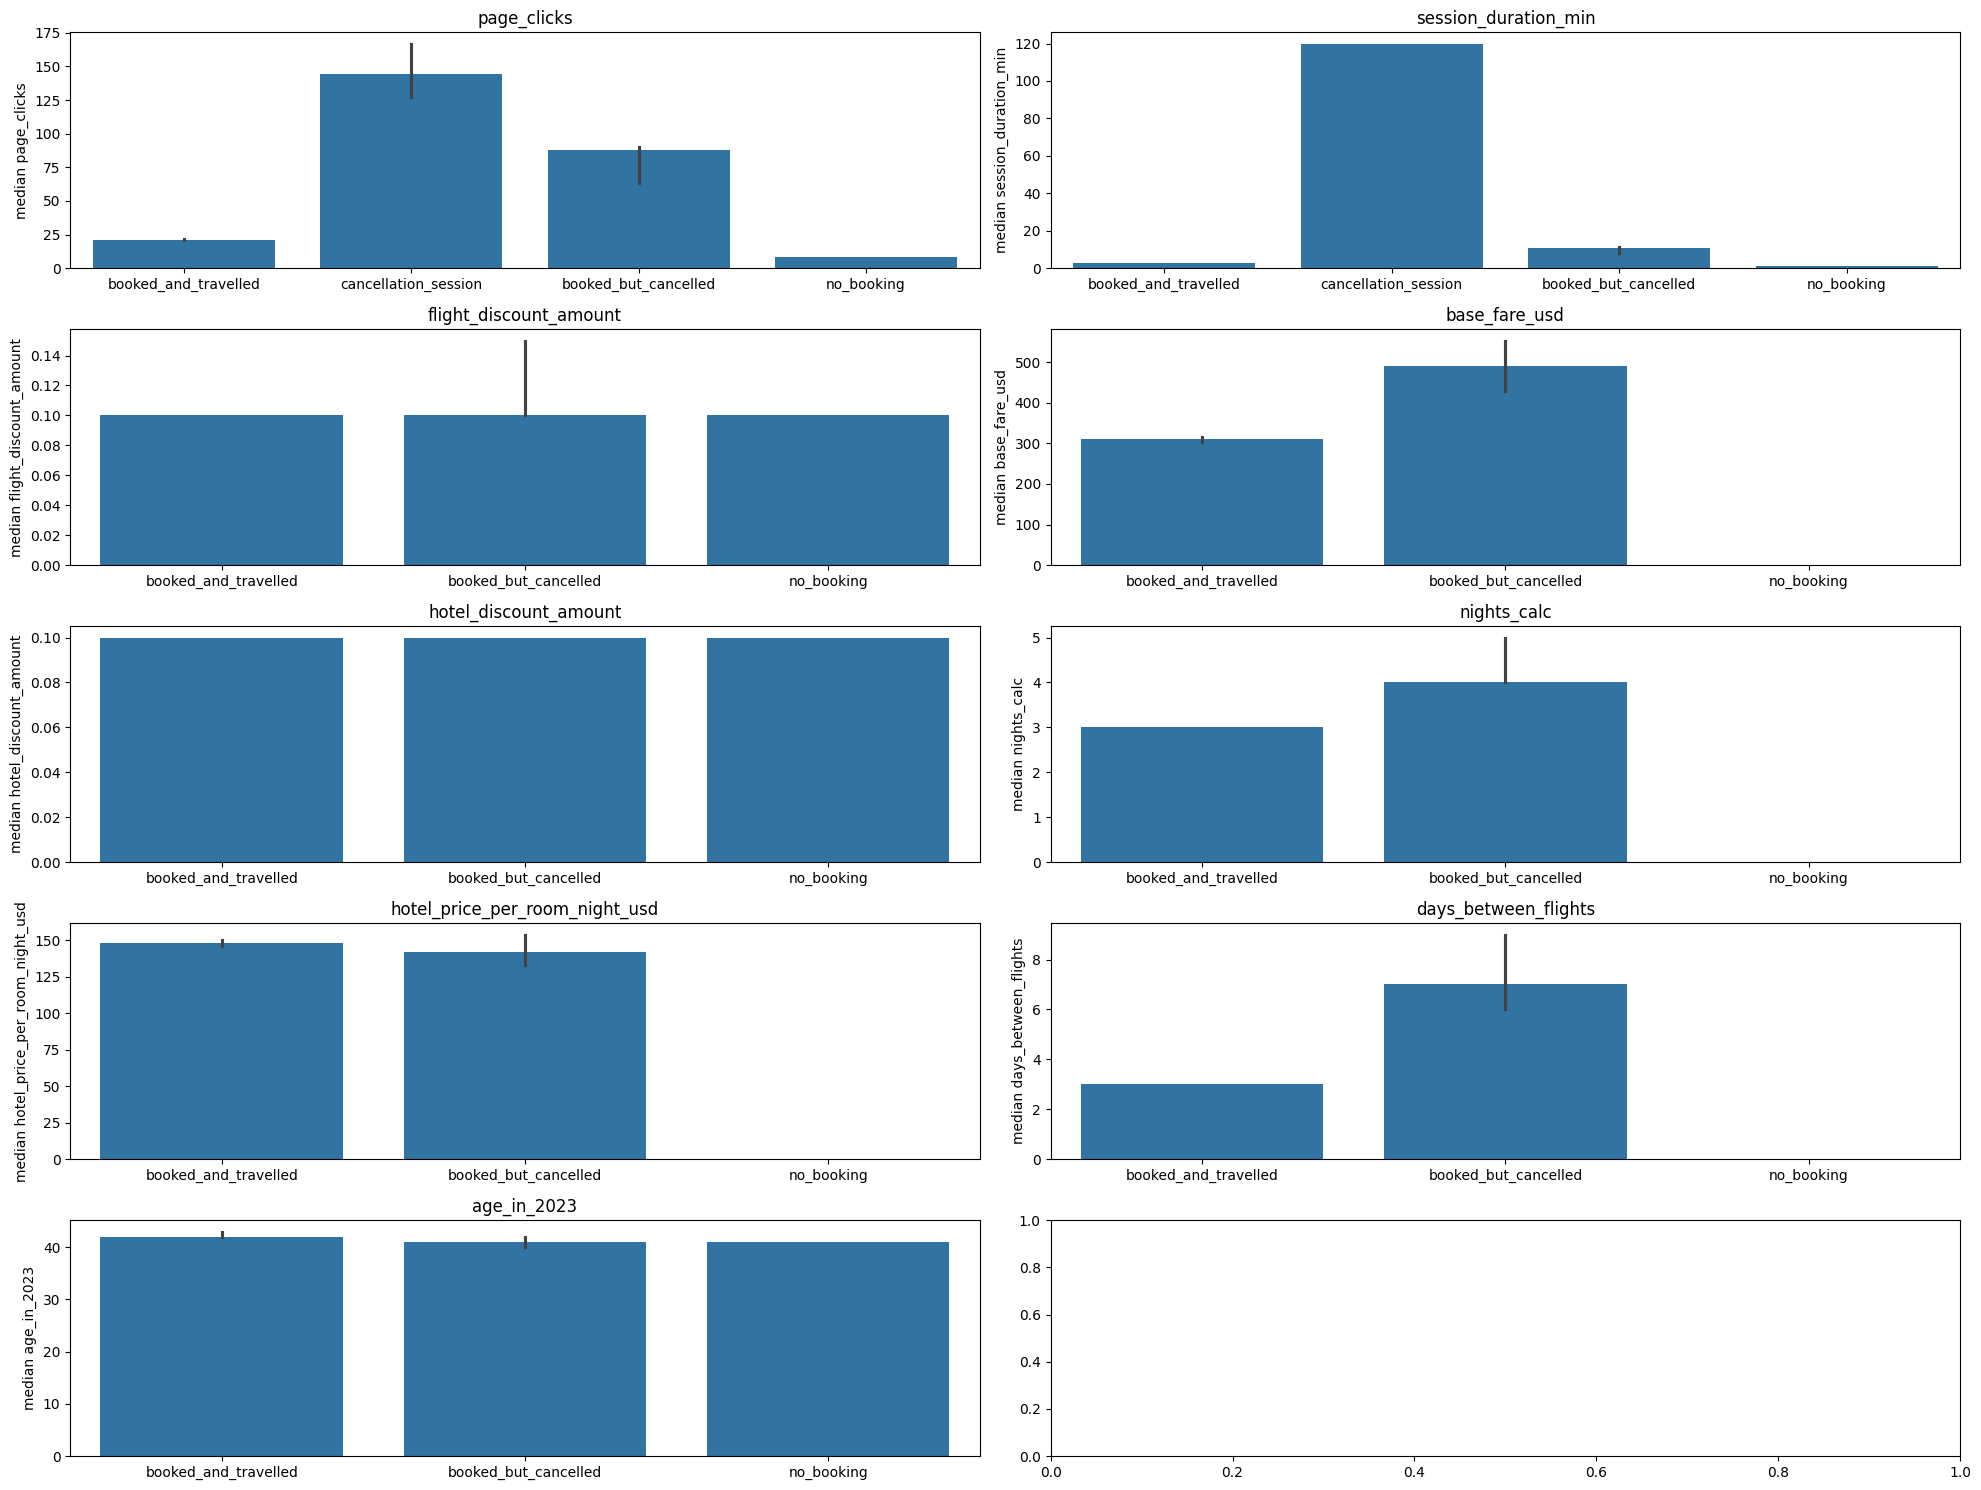

In [0]:
numer_feat_select = ['page_clicks', 'session_duration_min', 'flight_discount_amount', 'base_fare_usd', 'hotel_discount_amount', 'nights_calc', 'hotel_price_per_room_night_usd', 'days_between_flights', 'age_in_2023']

n_cols = 2

fig, axes = plt.subplots(nrows=int(np.ceil(len(numer_feat_select)/n_cols)), ncols=n_cols, figsize=(20,15))
for i, ax in zip(numer_feat_select, axes.flatten()):
    if i in ['page_clicks', 'session_duration_min']:
        sns.barplot(data=df, x='status', y=i, estimator=np.median, ax=ax)
    else:
        sns.barplot(data=df[df.status != 'cancellation_session'], x='status', y=i, estimator=np.median, ax=ax)
    ax.set_title(i)
    ax.set_xlabel("")
    ax.set_ylabel(f"median {i}")
    #plt.setp(ax.get_xticklabels(), rotation=30)
plt.tight_layout()
plt.show()

## some boolean features

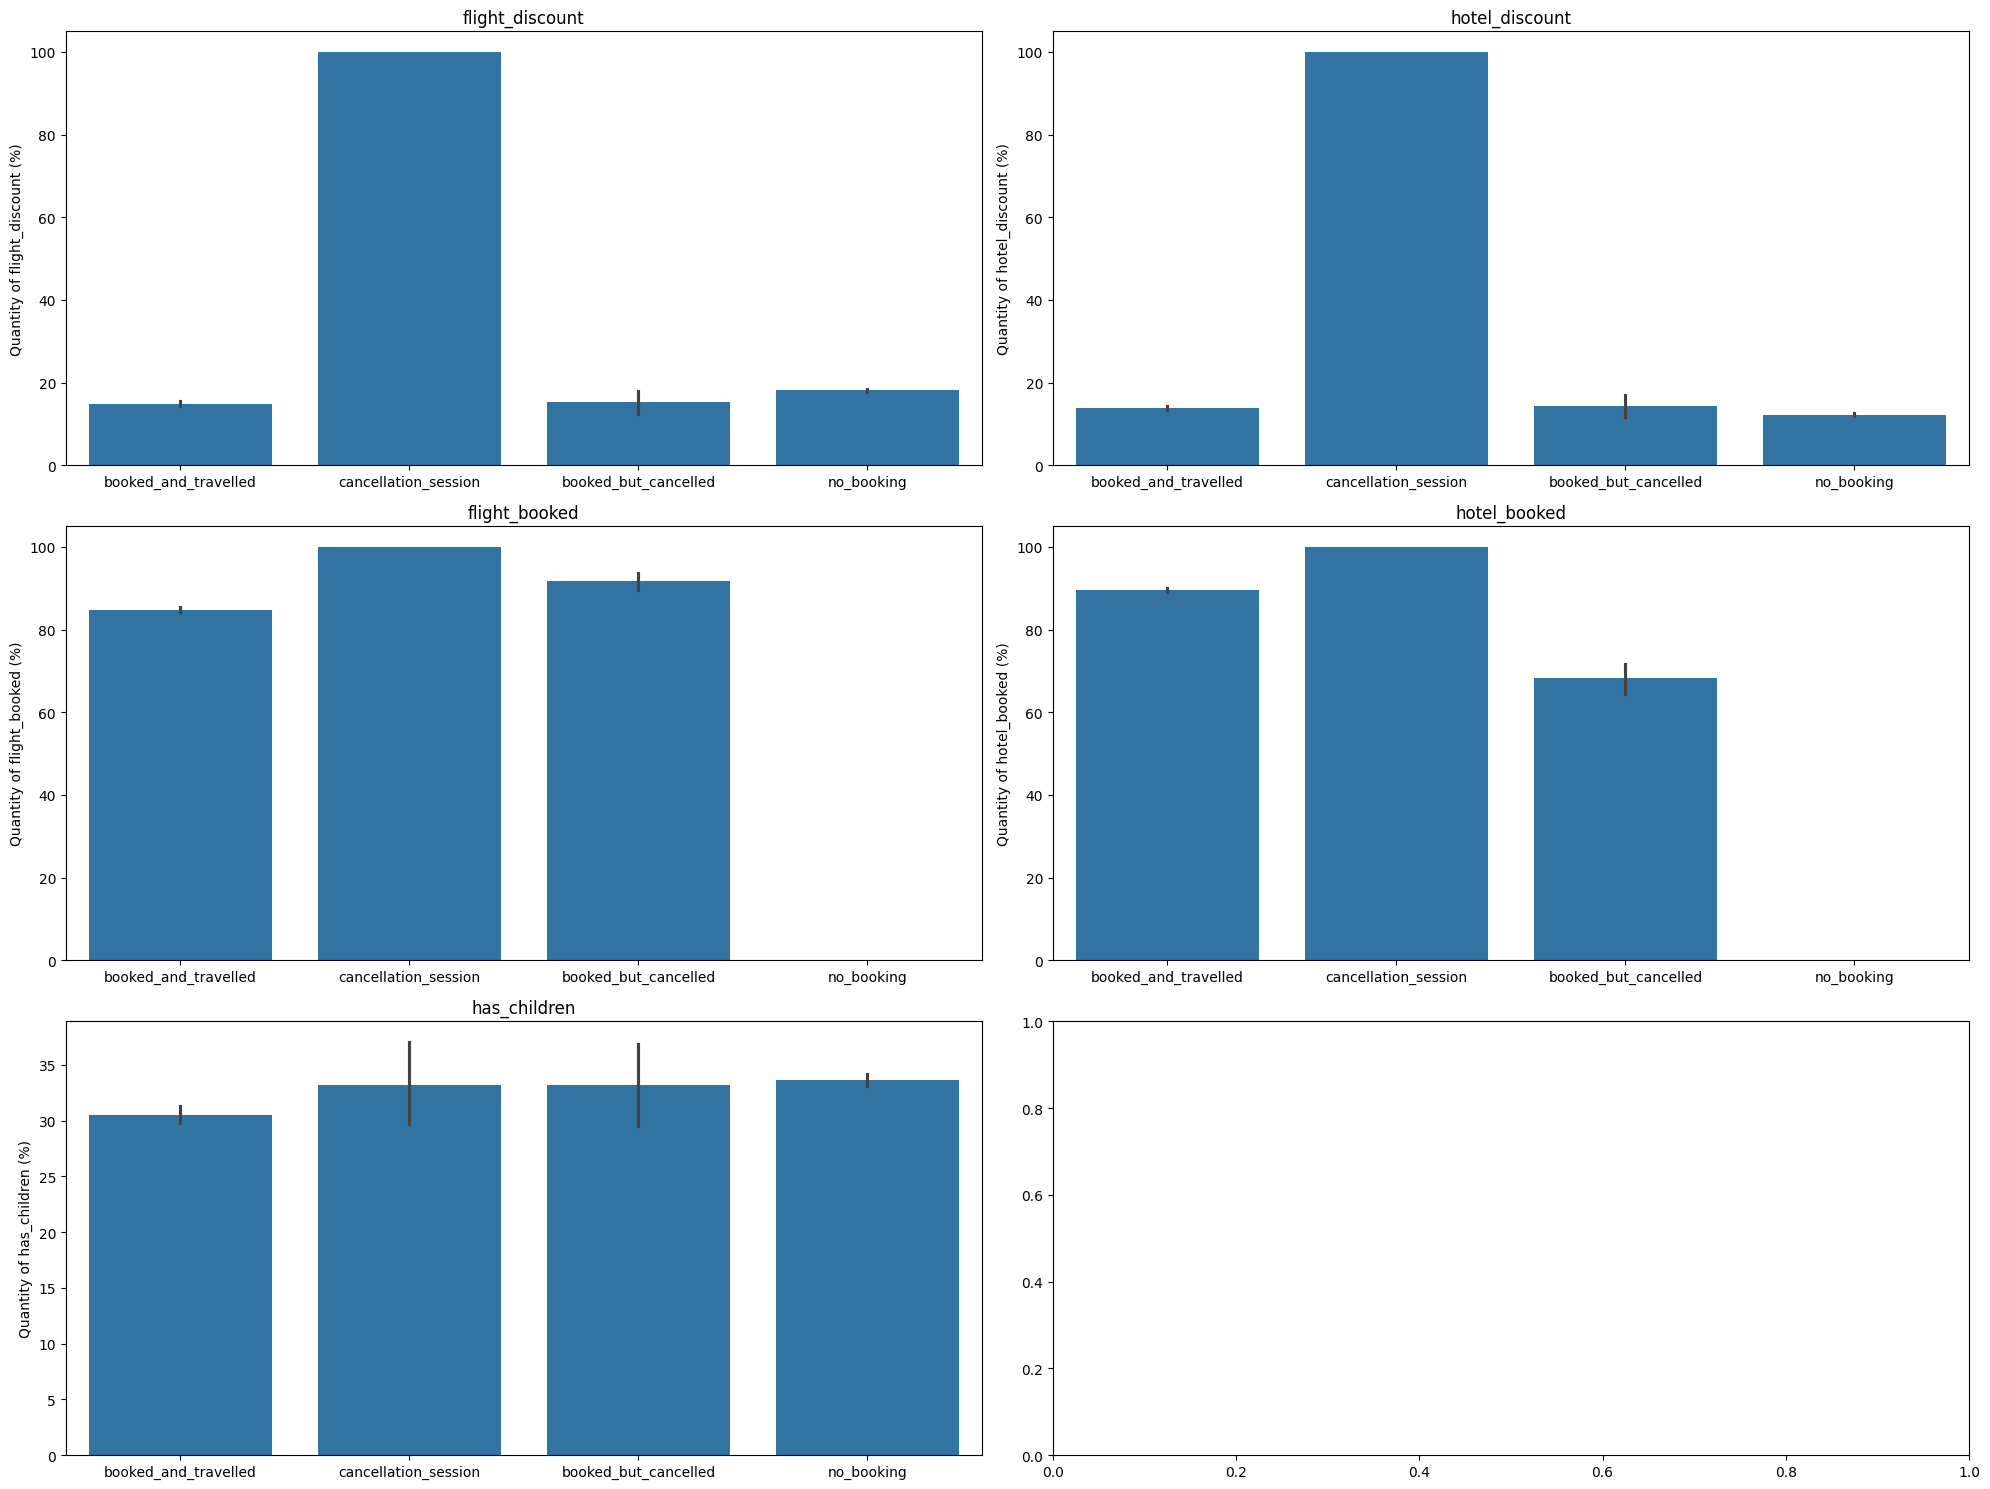

In [0]:
bool_feat_select = ['flight_discount', 'hotel_discount', 'flight_booked', 'hotel_booked', 'has_children']

n_cols = 2

fig, axes = plt.subplots(nrows=int(np.ceil(len(bool_feat_select)/n_cols)), ncols=n_cols, figsize=(20,15))
for i, ax in zip(bool_feat_select, axes.flatten()):
    sns.barplot(data=df, x='status', y=i, ax=ax, estimator=lambda x: np.mean(x == True)*100)
    ax.set_title(i)
    ax.set_ylabel(f"Quantity of {i} (%)")
    ax.set_xlabel("")
plt.tight_layout()
plt.show()

## booking status by age

In [0]:
AgeBin_Status_df = (df.groupby(['age_bin', 'status'], observed = False)['session_id'].count()/df.groupby('age_bin', observed = False)['session_id'].count()*100).reset_index()
AgeBin_Status_df['sessions_count']=df.groupby(['age_bin', 'status'], observed = False)['session_id'].count().reset_index(drop=True)
AgeBin_Status_df.rename(columns={'session_id': 'session_proportion'}, inplace=True)
AgeBin_Status_df.head(5)

,age_bin,status,session_proportion,sessions_count
0,"[17, 20)",booked_and_travelled,11.381789,285
1,"[17, 20)",booked_but_cancelled,1.637380,41
2,"[17, 20)",cancellation_session,1.637380,41
3,"[17, 20)",no_booking,85.343450,2137
4,"[20, 30)",booked_and_travelled,19.148187,1088


In [0]:
a = AgeBin_Status_df[AgeBin_Status_df.status == 'no_booking']
a

,age_bin,status,session_proportion,sessions_count
3,"[17, 20)",no_booking,85.343450,2137
7,"[20, 30)",no_booking,77.789511,4420
11,"[30, 40)",no_booking,62.855287,7740
15,"[40, 50)",no_booking,60.800000,10564
19,"[50, 60)",no_booking,63.530792,5416
23,"[60, 70)",no_booking,81.910896,1526
27,"[70, 80)",no_booking,87.955182,628
31,"[80, 90)",no_booking,81.250000,78


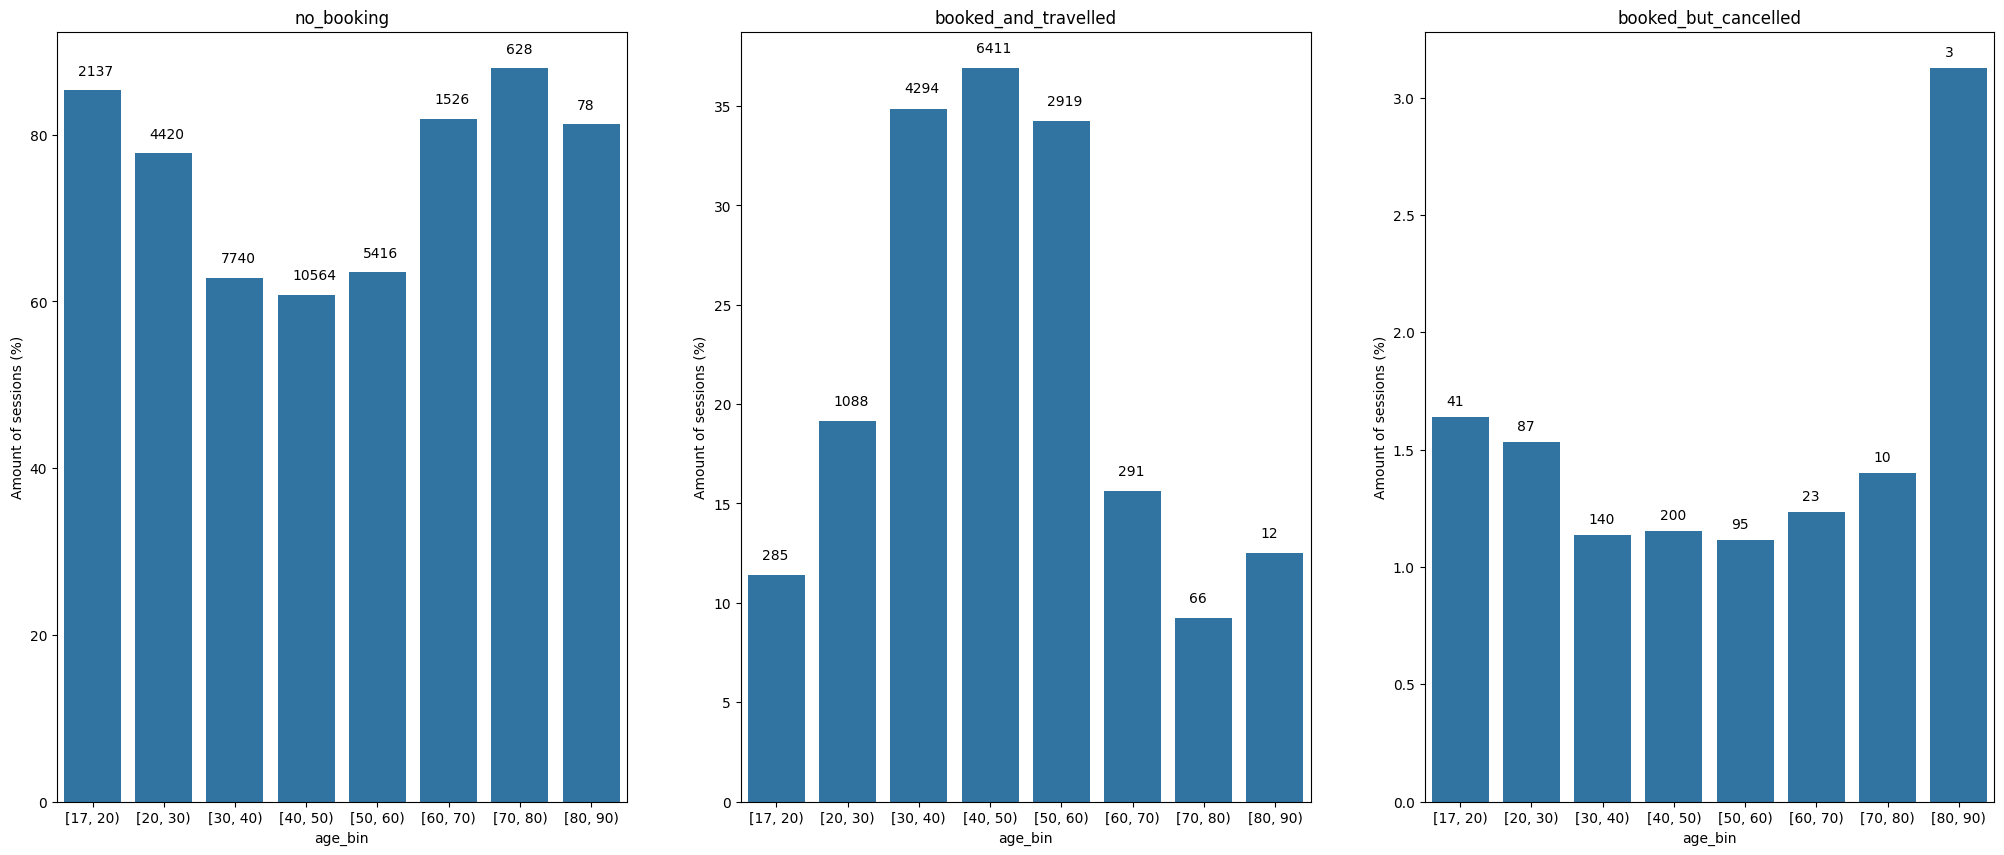

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,10))

for i, ax in zip(['no_booking', 'booked_and_travelled', 'booked_but_cancelled'], axes.flatten()):
    a = sns.barplot(data=AgeBin_Status_df[AgeBin_Status_df.status == i], x='age_bin', y='session_proportion', ax=ax)
    
    x_pos = -0.2
    for ind in AgeBin_Status_df[AgeBin_Status_df.status == i].index:
        
        if i == 'no_booking':
            y_adj = 1.8
        elif i == 'booked_and_travelled':
            y_adj = 0.8
        elif i == 'booked_but_cancelled':
            y_adj = 0.05
        
        ax.text(
            x = x_pos,
            y = AgeBin_Status_df.loc[ind, 'session_proportion'] +  y_adj,
            s = AgeBin_Status_df.loc[ind, 'sessions_count']
        )
        x_pos+=1
    
    ax.set_title(i)
    ax.set_ylabel(f"Amount of sessions (%)")


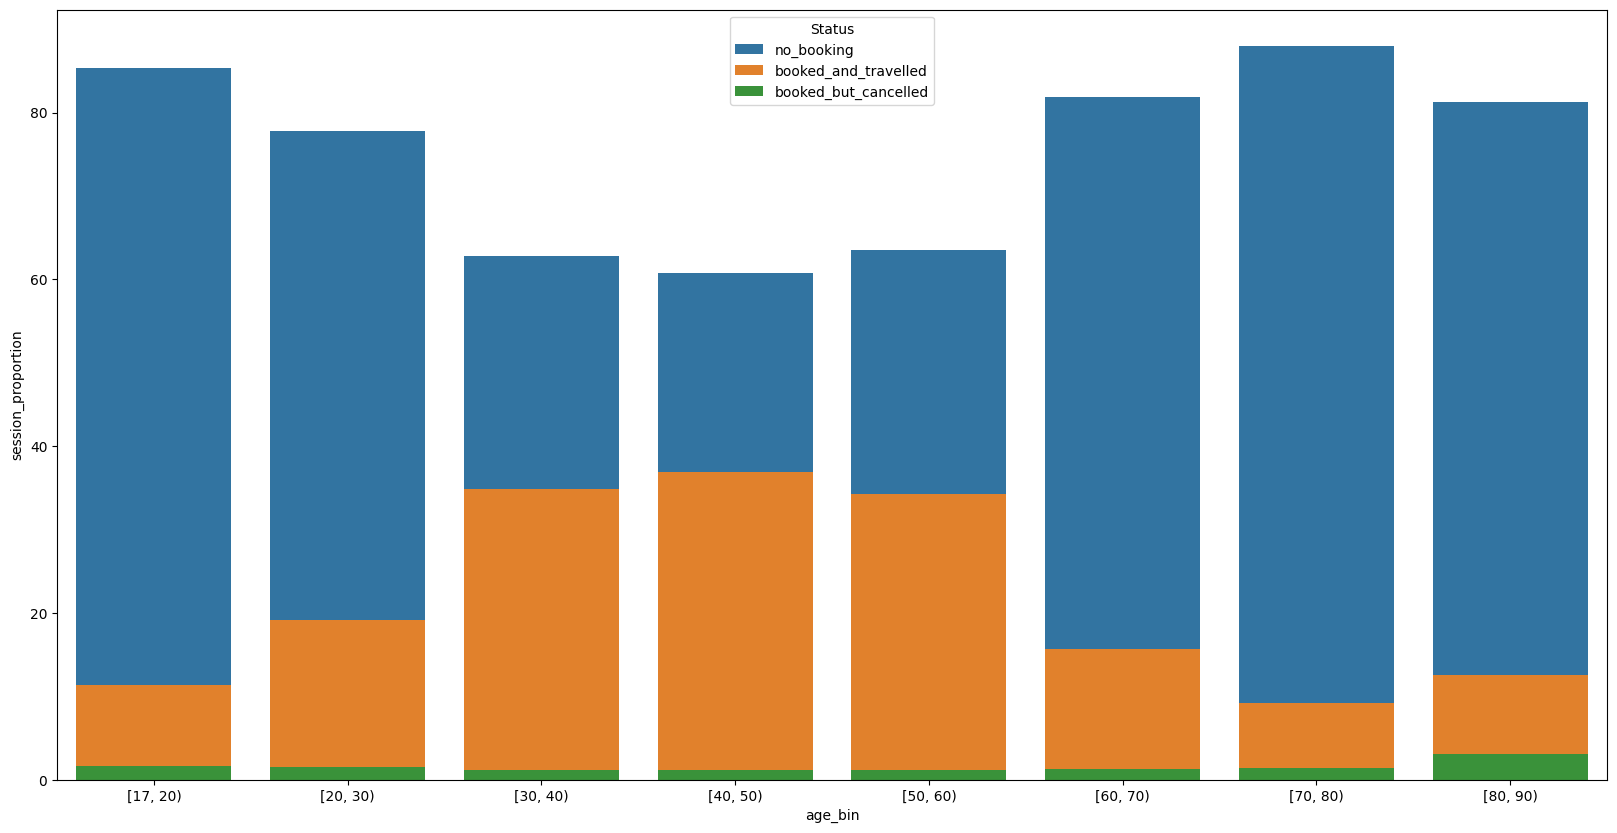

In [0]:
plt.figure(figsize=(20,10))
colors = {'no_booking': 'tab:blue', 'booked_and_travelled': 'tab:orange', 'booked_but_cancelled': 'tab:green'}
bars = []

bars.append(sns.barplot(data=AgeBin_Status_df[AgeBin_Status_df.status == 'no_booking'], x='age_bin', y='session_proportion', 
color=colors['no_booking'], label='no_booking'))

bars.append(sns.barplot(data=AgeBin_Status_df[AgeBin_Status_df.status == 'booked_and_travelled'], x='age_bin', y='session_proportion', color=colors['booked_and_travelled'], label='booked_and_travelled'))

bars.append(sns.barplot(data=AgeBin_Status_df[AgeBin_Status_df.status == 'booked_but_cancelled'], x='age_bin', y='session_proportion', color=colors['booked_but_cancelled'], label='booked_but_cancelled'))

plt.legend(title="Status")
plt.show()

In [0]:
df.columns

Index(['session_id', 'user_id', 'trip_id', 'session_start', 'session_end',
       'page_clicks', 'flight_discount', 'flight_discount_amount',
       'hotel_discount', 'hotel_discount_amount', 'flight_booked',
       'hotel_booked', 'cancellation', 'birthdate', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'origin_airport', 'destination', 'destination_airport', 'seats',
       'return_flight_booked', 'departure_time', 'return_time', 'checked_bags',
       'trip_airline', 'destination_airport_lat', 'destination_airport_lon',
       'base_fare_usd', 'hotel_name', 'nights_calc', 'rooms', 'check_in_time',
       'check_out_time', 'hotel_price_per_room_night_usd', 'age_in_2023',
       'session_duration_min', 'days_between_flights', 'age_bin', 'status',
       'distance_km', 'duration', 'session_cost', 'booking_window_days',
       'family_session'],
      dtype='object')

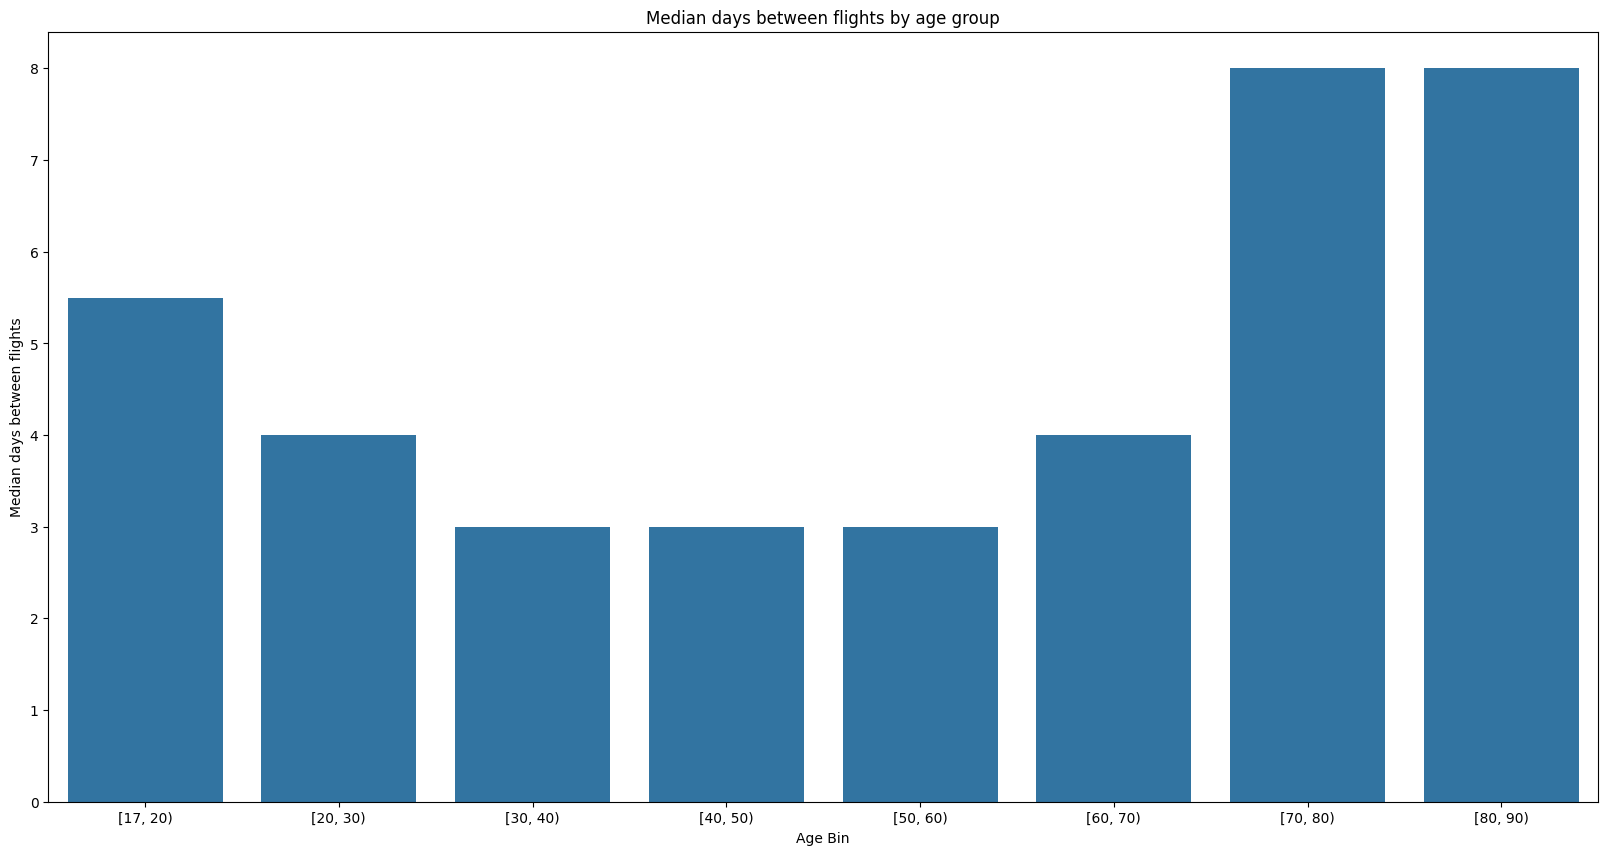

In [0]:
plt.figure(figsize=(20,10))
sns.barplot(data=df, x='age_bin', y='days_between_flights', estimator='median', errorbar=None)
plt.title("Median days between flights by age group")
plt.xlabel("Age Bin")
plt.ylabel("Median days between flights")
plt.show()

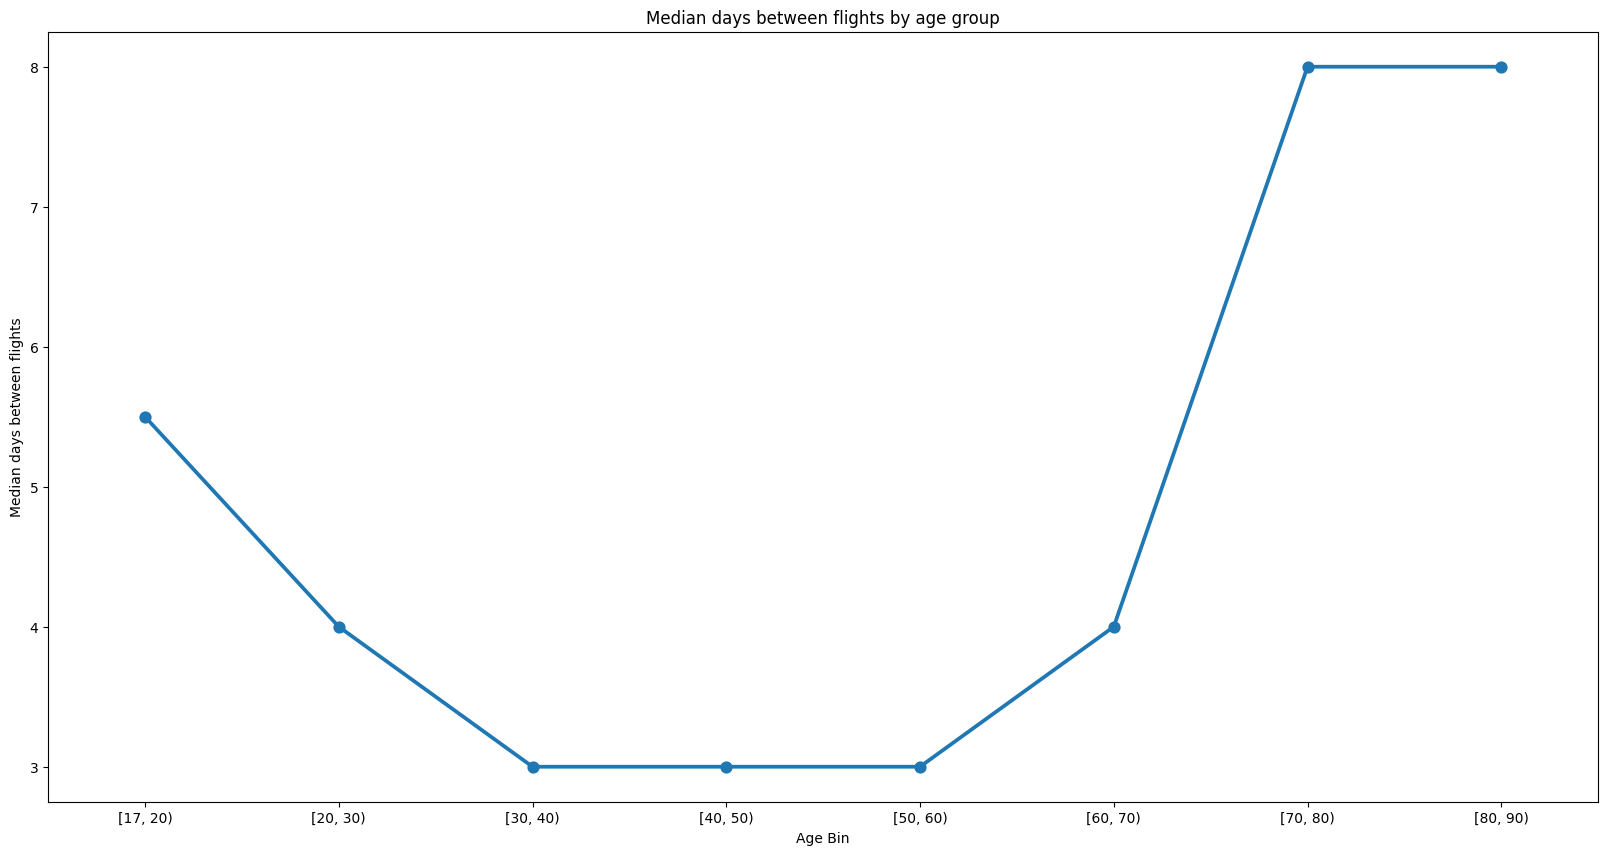

In [0]:
plt.figure(figsize=(20,10))
sns.pointplot(data=df, x='age_bin', y='days_between_flights', estimator='median', errorbar=None)
plt.title("Median days between flights by age group")
plt.xlabel("Age Bin")
plt.ylabel("Median days between flights")
plt.show()

## distance and days

EDA

In [0]:
df_booked = df[(df.status == 'booked_and_travelled') | (df.status == 'booked_but_cancelled')]
#it was already defined, but we need from here on, so I will define it again

distance

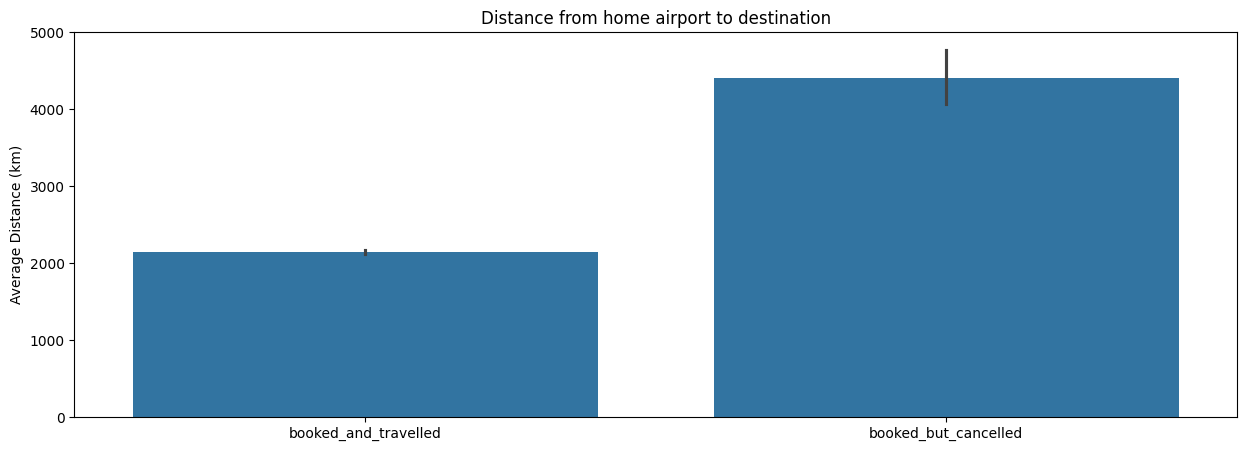

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=df_booked, x='status', y='distance_km')
plt.title('Distance from home airport to destination')
plt.xlabel('')
plt.ylabel('Average Distance (km)')
plt.show()


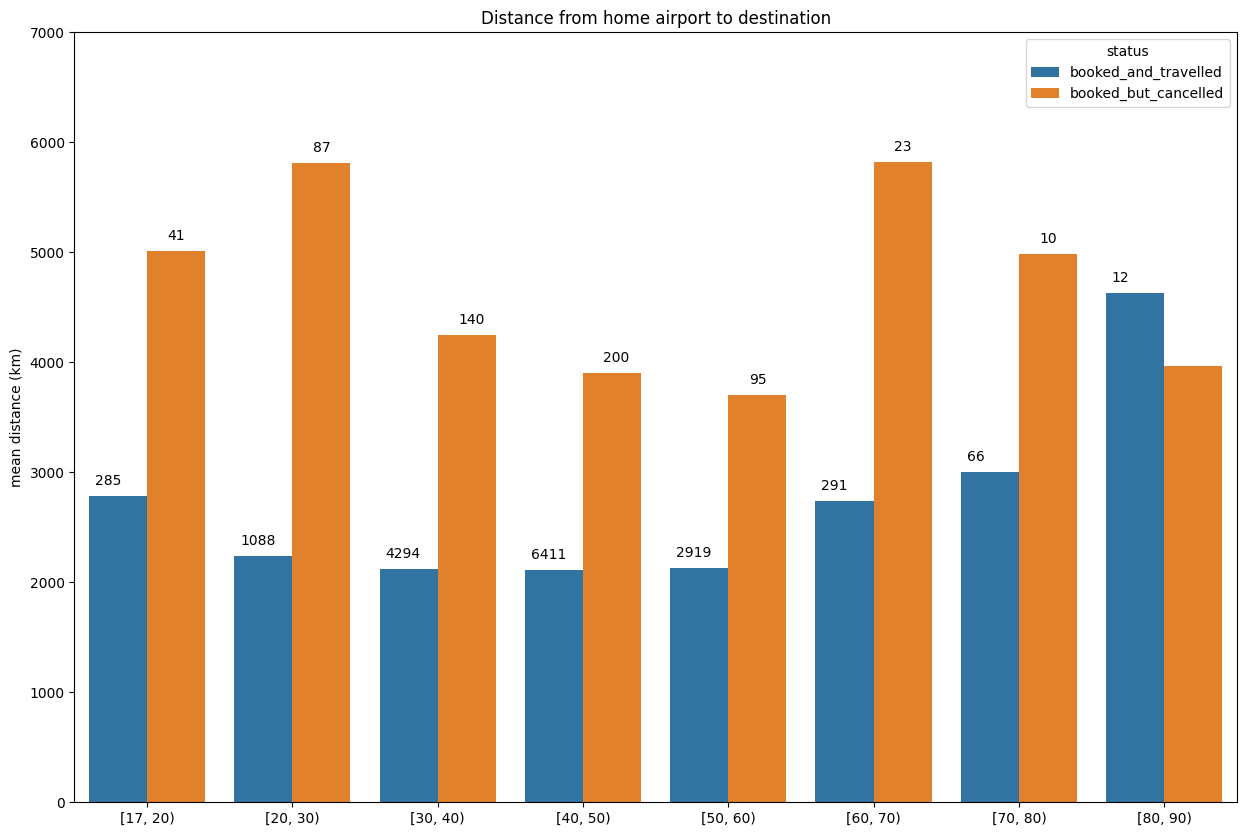

In [0]:
estimator_distance = 'mean'

#labels for bars in plot
labels_count = df_booked.groupby(["age_bin", "status"], observed=False)["session_id"].count().reset_index()
labels_dist = df_booked.groupby(["age_bin", "status"], observed=False)["distance_km"].apply(estimator_distance).reset_index(drop=True)
labels = pd.concat([labels_count, labels_dist], axis = 1)

#barplot creation
plt.figure(figsize=(15,10))
ax = sns.barplot(data=df_booked, x='age_bin', y='distance_km', hue='status', estimator=estimator_distance, errorbar=None)
plt.title('Distance from home airport to destination')
plt.xlabel('')
plt.ylabel(f'{estimator_distance} distance (km)')
plt.ylim(0,7000)

x_pos = -0.36
for y_pos in range(0,15):
    ax.text(x=x_pos, y=labels.distance_km[y_pos]+100, s=labels.session_id[y_pos])
    x_pos += 0.5

plt.show()

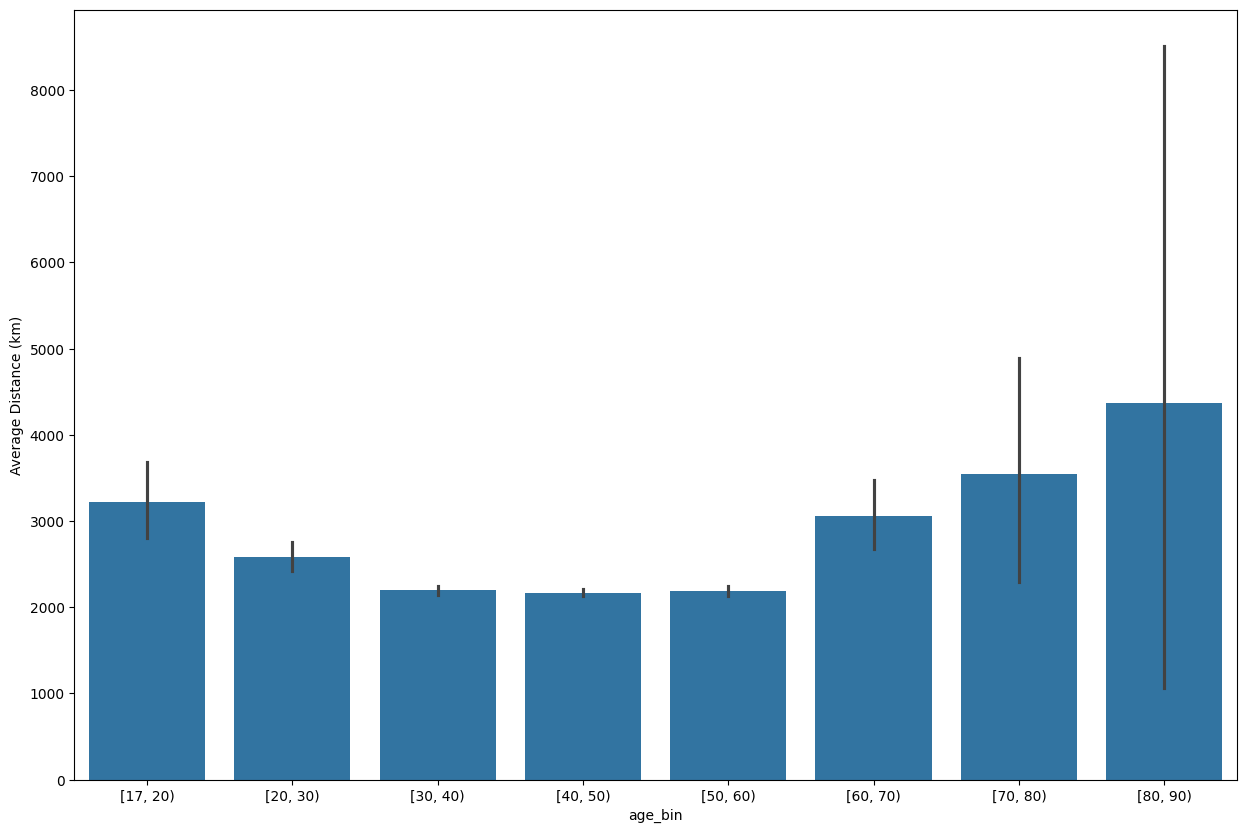

In [0]:
plt.figure(figsize=(15,10))
sns.barplot(data=df_booked, x='age_bin', y='distance_km', estimator='mean')#, errorbar=None)
plt.ylabel('Average Distance (km)')
plt.show()

days

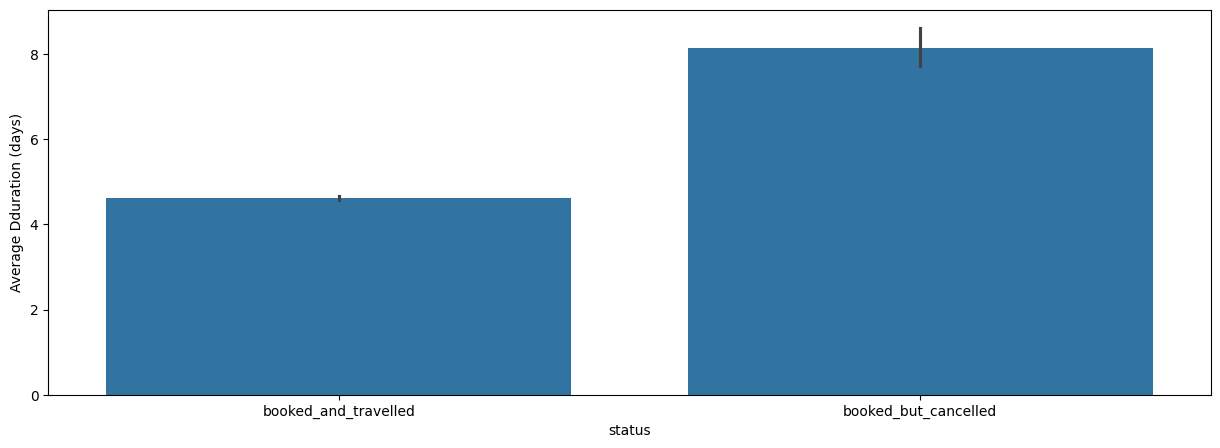

In [0]:
plt.figure(figsize=(15,5))
sns.barplot(data=df_booked, x='status', y='duration', estimator='mean')
plt.ylabel('Average Dduration (days)')
plt.show()

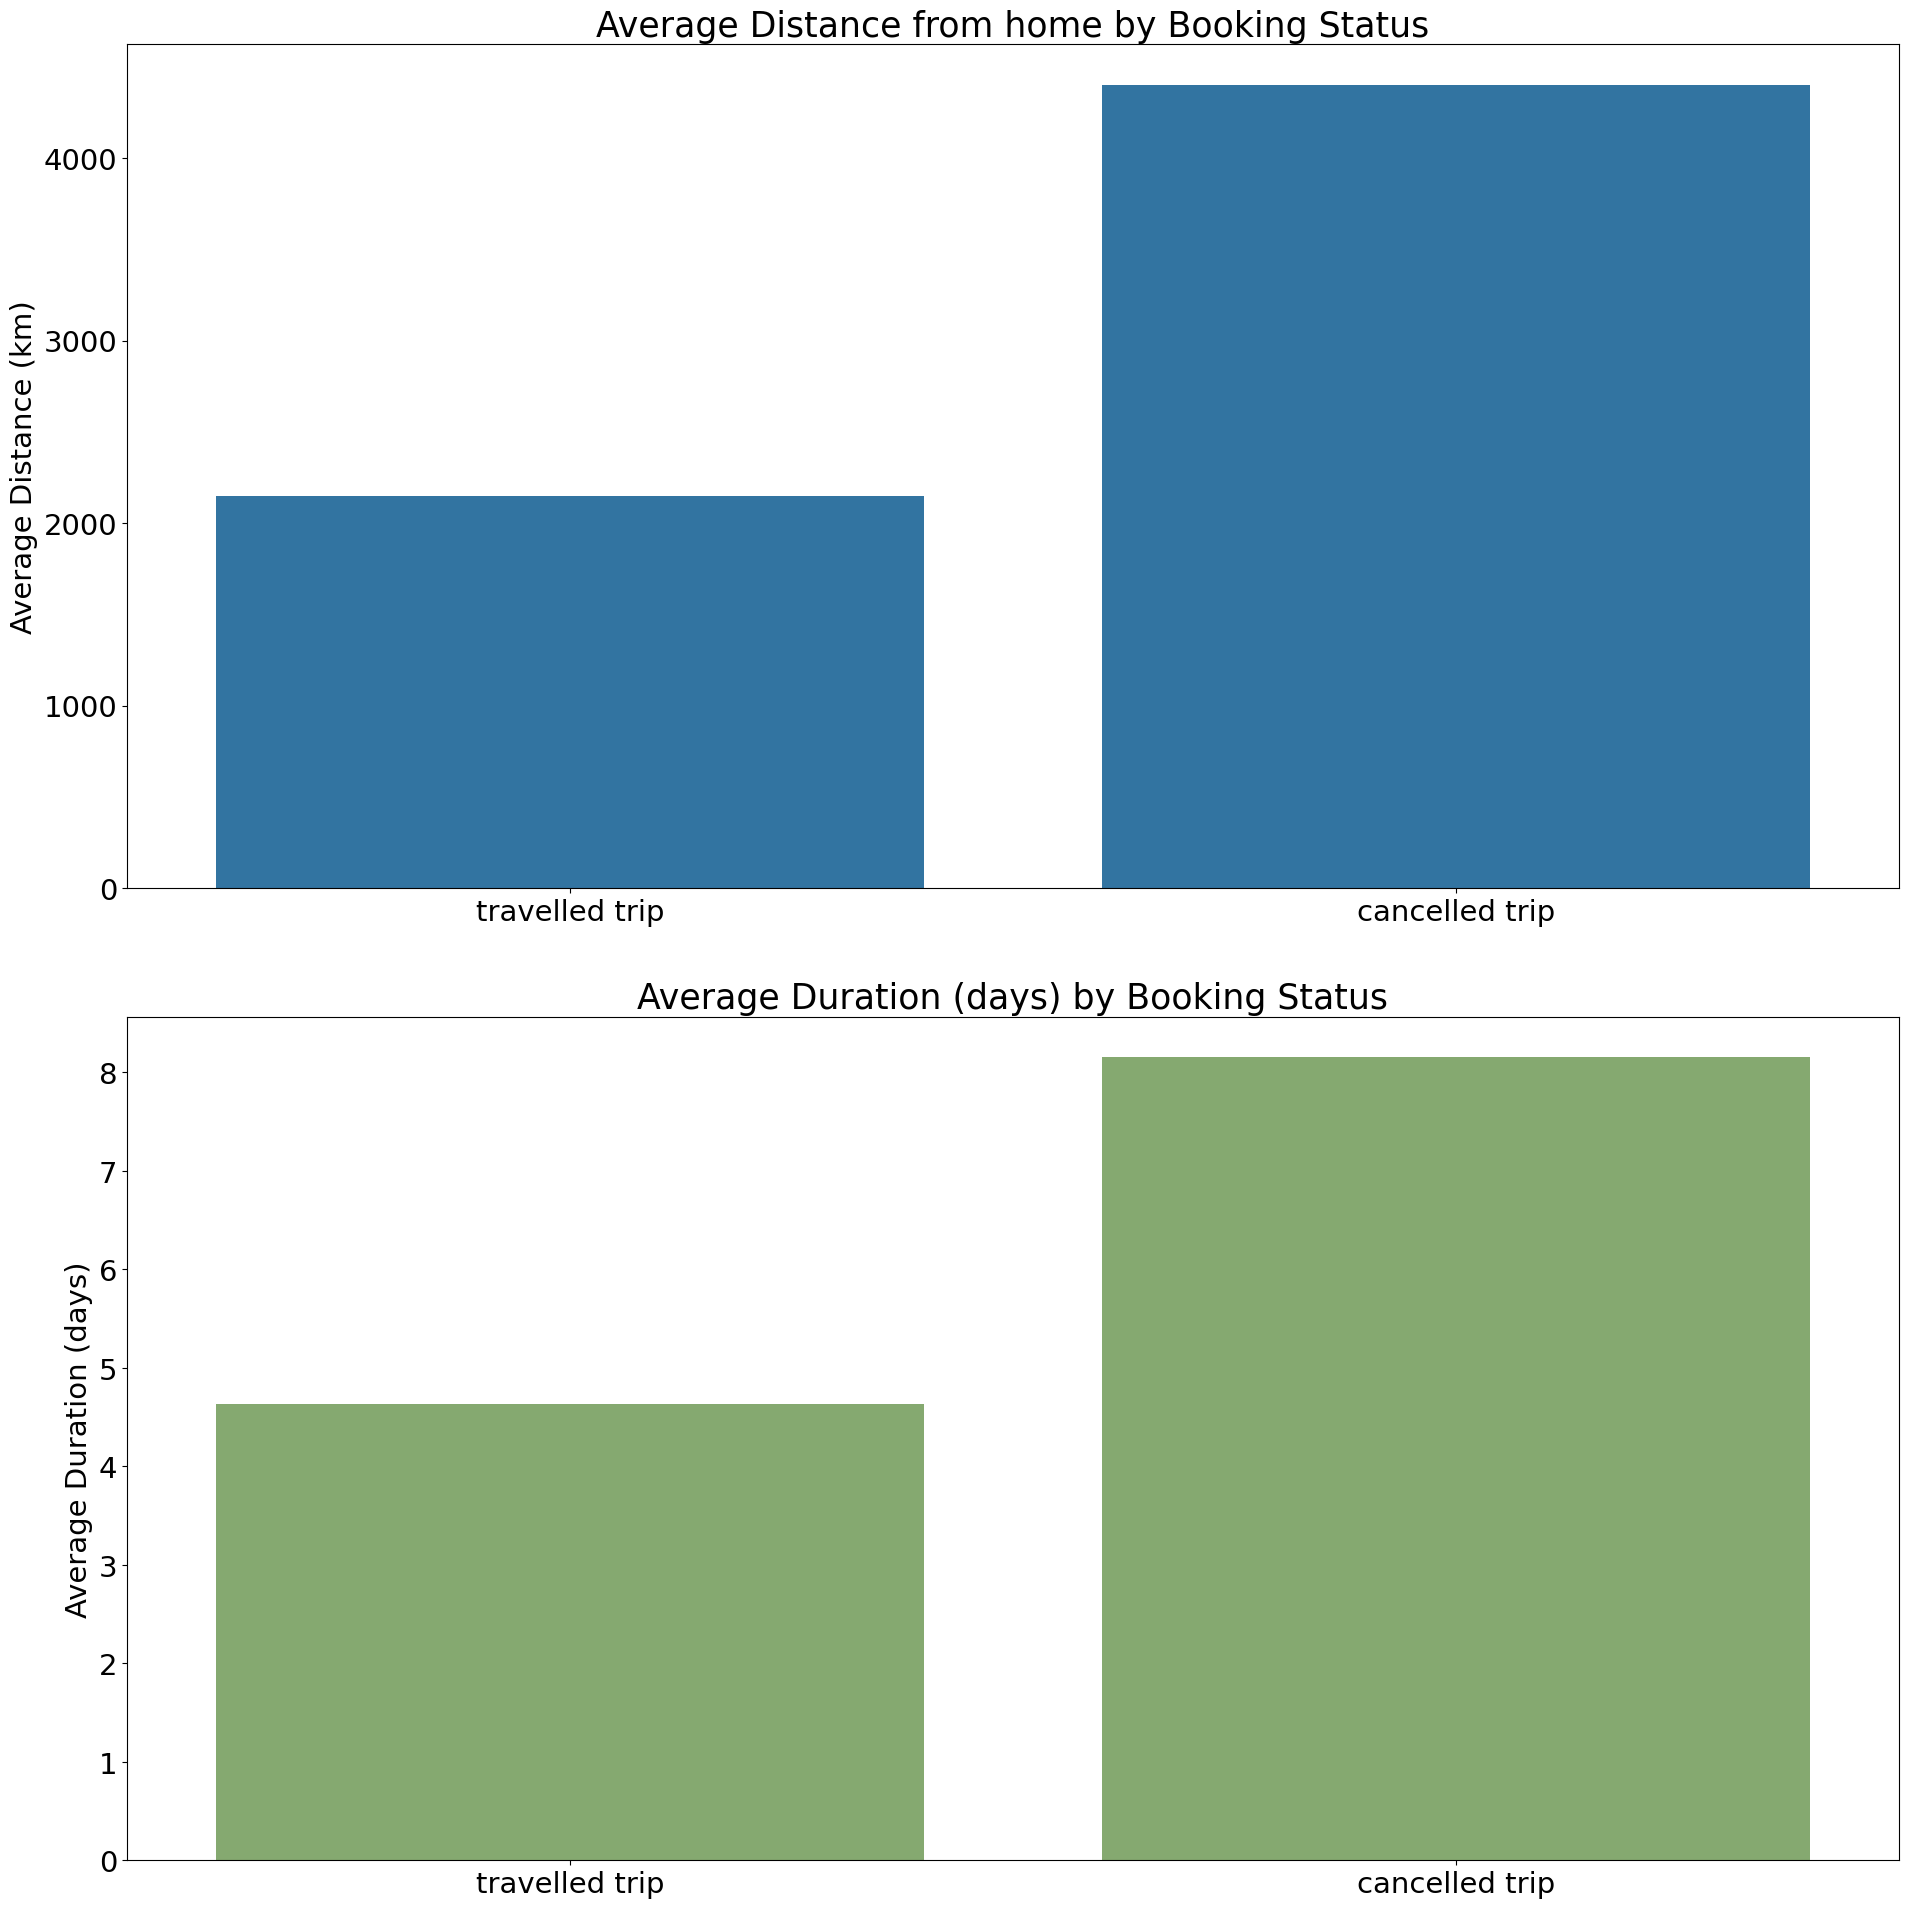

In [0]:
plt.figure(figsize=(20,20))

# Mappa per cambiare le etichette
status_labels = {'booked_and_travelled': 'travelled trip', 'booked_but_cancelled': 'cancelled trip'}
df_booked_plot = df_booked.copy()
df_booked_plot['status'] = df_booked_plot['status'].map(status_labels)

# Primo barchart: distanza
plt.subplot(2,1,1)
sns.barplot(data=df_booked_plot, x='status', y='distance_km', errorbar=None)
plt.title('Average Distance from home by Booking Status', fontsize=25)
plt.xlabel('', fontsize=21)
plt.ylabel('Average Distance (km)', fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)

# Secondo barchart: durata, colorato
plt.subplot(2,1,2)
sns.barplot(data=df_booked_plot, x='status', y='duration', estimator='mean', errorbar=None, color='#82B366')
plt.title('Average Duration (days) by Booking Status', fontsize=25)
plt.xlabel('', fontsize=21)
plt.ylabel('Average Duration (days)', fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)

plt.tight_layout(pad=4)
plt.show()

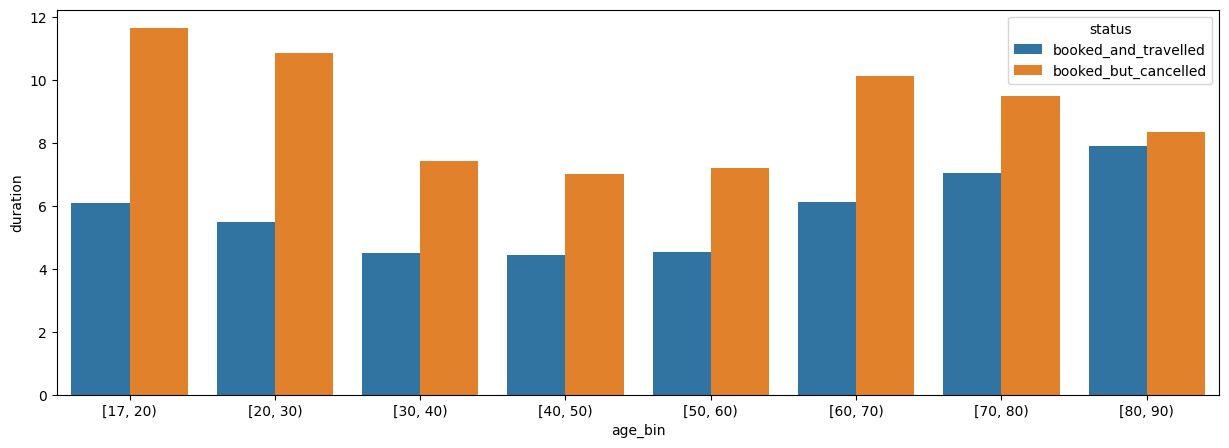

In [0]:
#barplot creation
plt.figure(figsize=(15,5))
ax = sns.barplot(data=df_booked, x='age_bin', y='duration', hue='status', estimator='mean', errorbar=None)
plt.show()

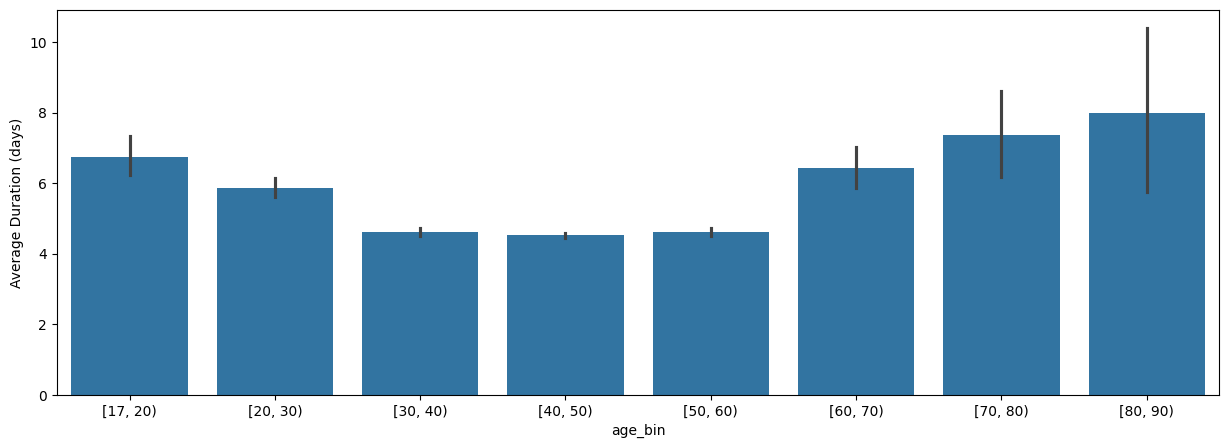

In [0]:
#barplot creation
plt.figure(figsize=(15,5))
ax = sns.barplot(data=df_booked, x='age_bin', y='duration', estimator='mean')#, errorbar=None)
plt.ylabel('Average Duration (days)')
plt.show()

#OTHER EDA

In [0]:
df.columns

Index(['session_id', 'user_id', 'trip_id', 'session_start', 'session_end',
       'page_clicks', 'flight_discount', 'flight_discount_amount',
       'hotel_discount', 'hotel_discount_amount', 'flight_booked',
       'hotel_booked', 'cancellation', 'birthdate', 'gender', 'married',
       'has_children', 'home_country', 'home_city', 'home_airport',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'origin_airport', 'destination', 'destination_airport', 'seats',
       'return_flight_booked', 'departure_time', 'return_time', 'checked_bags',
       'trip_airline', 'destination_airport_lat', 'destination_airport_lon',
       'base_fare_usd', 'hotel_name', 'nights_calc', 'rooms', 'check_in_time',
       'check_out_time', 'hotel_price_per_room_night_usd', 'age_in_2023',
       'session_duration_min', 'days_between_flights', 'age_bin', 'status',
       'distance_km', 'duration', 'session_cost', 'booking_window_days',
       'family_session'],
      dtype='object')

In [0]:
def family_session(row):
    if row.has_children == False:
        return 'no_family_session'
    if row['seats'] > 1:
        return 'family_session'
    elif row['rooms'] > 1:
        return 'family_session'
    else:
        return 'no_family_session'

In [0]:
df.shape

(49073, 51)

In [0]:
df.apply(lambda row: family_session(row), axis=1).value_counts()

no_family_session    48131
family_session         942
Name: count, dtype: int64